# PROJET SEATTLE ENERGY BENCHMARKING
## Notebook 01 : Évaluation  de la qualité des données

---

### Identité du document
* **Statut :** Phase 1 (exploration & prototypage)
* **Date de création :** 29 Décembre 2025
* **Dernière mise à jour :** 31 Décembre 2025
* **Dépendances notebooks** : Notebook 0

### Description
Effectuer un audit exhaustif de la qualité des données pour identifier les problèmes potentiels avant toute analyse approfondie. Cela permet d'éviter des biais dans les étapes ultérieures et de documenter un plan de nettoyage clair.

> **Philosophie :** "Mieux vaut détecter les problèmes maintenant que découvrir qu'on a analysé des données biaisées après 2 semaines de travail."

### Objectifs principaux
1. **Cartographier** la complétude des données (analyse des NaN).
2. **Distinguer** les erreurs manifestes des valeurs extrêmes légitimes.
3. **Valider** la cohérence interne (logique métier et physique).
4. **Évaluer** l'impact du flag `DefaultData`.
5. **Produire** un plan d'action pour le nettoyage.

### Dépendances critiques
* `hydra` : Gestion de configuration.
* `pandas`, `seaborn`, `matplotlib` : Manipulation et inspection visuelle.
* `src.data_quality/` : Fonctions à construire.

### LIVRABLES
1. **Rapport de Qualité**  : Synthèse des constats.
2. **Matrice de Stratégie**  : Plan d'action ligne par ligne.
3. **Figures d'audit** : Preuves visuelles.

---

---
# Table des Matières
- [Section 0 : Importation et chargement](#section-0--importation-et-chargement)
- [Section 1 : Où sont les données manquantes et pourquoi ? (Completeness)](#section-1--où-sont-les-données-manquantes-et-pourquoi)
- [Section 2 : Les valeurs extrêmes sont-elles des erreurs ou des réalités ? (Outliers)](#section-2--les-valeurs-extrêmes-sont-elles-des-erreurs-ou-des-réalités)
- [Section 3 : Les données respectent-elles la logique physique et métier ? (Consistency)](#section-3--les-données-respectent-elles-la-logique-physique-et-métier)
- [Section 4 : Le flag "DefaultData" compromet-il la fiabilité ? (Reliability)](#section-4--le-flag-defaultdata-compromet-il-la-fiabilité)
- [Section 5 : Existe-t-il des doublons ou des quasi-doublons ? (Uniqueness)](#section-5--existe-t-il-des-doublons-ou-des-quasi-doublons)
- [Section 6 : Quelle stratégie de nettoyage adopter ? (Action Plan)](#section-6--quelle-stratégie-de-nettoyage-adopter)

---

# Section 0 : Importation et chargement

## Importation des packages

In [2]:
import logging
import pandas as pd
from pathlib import Path


# Import des fonctions utilitaires 

import sys

PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))


from data.load_data import load_data_raw
from utils.config_loader import load_config, create_directories
from utils.eda_logger import setup_eda_logger

# graphique package
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np

# statistiques
from scipy.stats import chi2_contingency
from scipy import stats

# regex pour netoiyer nom colonne (exportation)
import re

 


## init config et chargement

In [3]:
# Chargement de la configuration principale (Hydra)
cfg = load_config()

# Initialisation du logger
setup_eda_logger(cfg)
logger = logging.getLogger(__name__)

# Création des dossiers nécessaires à l'exécution (raw, interim, processed, reports, etc.)
create_directories(cfg)
# Chargement des données brutes

# Forcer pandas à afficher toutes les colonnes
pd.set_option("display.max_columns", None)

# Forcer pandas à afficher toutes les lignes (si besoin)
pd.set_option("display.max_rows", None)

# Forcer pandas à afficher toute la largeur (évite les "...")
pd.set_option("display.width", None)



df_raw = load_data_raw(cfg)

# Validation dimensions
n_rows, n_cols = df_raw.shape
logger.info(f"Dataset chargé ({n_rows} lignes, {n_cols} colonnes)")

# Premier aperçu
df_raw.sample(5)


2026-01-01 17:02:34,870 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\raw
2026-01-01 17:02:34,870 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\interim
2026-01-01 17:02:34,870 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\processed
2026-01-01 17:02:34,875 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\figures
2026-01-01 17:02:34,877 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\reports
2026-01-01 17:02:34,918 - data.load_data - INFO - DataFrame chargé : 3376 lignes, 46 colonnes
2026-01-01 17:02:34,957 - data.load_data - INFO -  Intégrité des données validée (Aucune modification détectée).
2026-01-01 17:02:34,957 - __main__ - INFO - Dataset chargé (

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
2730,26743,2016,Multifamily MR (5-9),Mid-Rise Multifamily,Lakeside West,2040 43rd Avenue e,Seattle,WA,98112.0,4143000000,3,EAST,47.63828,-122.27635,1961,1.0,6,80539,0,80539,Multifamily Housing,Multifamily Housing,66307.0,NaN,NaN,NaN,NaN,NaN,22.0,102.199997,112.800003,148.800003,159.899994,6779778.00,7.481662e+06,0.0,385546.5938,1315485.0,54642.925780,5464293.0,False,NaN,Compliant,NaN,299.38,3.72
1274,21423,2016,Multifamily MR (5-9),Mid-Rise Multifamily,Axis Apartments,123 2nd Ave N,Seattle,WA,98109.0,1985200070,7,MAGNOLIA / QUEEN ANNE,47.61934,-122.35322,2008,1.0,7,178911,0,178911,"Multifamily Housing, Parking",Multifamily Housing,184395.0,Parking,36878.0,NaN,NaN,NaN,97.0,28.400000,29.299999,58.500000,59.400002,5232420.50,5.400862e+06,0.0,741602.5000,2530348.0,27020.720700,2702072.0,False,NaN,Compliant,NaN,161.15,0.90
160,257,2016,NonResidential,Warehouse,Harbor Island: Warehouse E - DNRP-SWD,3235 16TH AVE SW,Seattle,WA,98134.0,7666703020,1,GREATER DUWAMISH,47.57507,-122.35747,1916,0.0,4,79600,0,79600,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,79600.0,NaN,NaN,NaN,NaN,NaN,34.0,30.299999,30.299999,95.099998,95.099998,2411402.25,2.411402e+06,0.0,706741.5000,2411402.0,0.000000,0.0,False,NaN,Compliant,NaN,16.81,0.21
1394,21691,2016,Multifamily MR (5-9),Mid-Rise Multifamily,VIEW 222 (ID21691),222 QUEEN ANNE AVE N,Seattle,WA,98109.0,1989201300,7,MAGNOLIA / QUEEN ANNE,47.62044,-122.35650,2009,1.0,7,32143,0,32143,Multifamily Housing,Multifamily Housing,22852.0,NaN,NaN,NaN,NaN,NaN,53.0,55.200001,56.599998,120.400002,122.000000,1260416.00,1.294294e+06,0.0,200392.0938,683738.0,5766.779785,576678.0,False,NaN,Compliant,NaN,35.39,1.10
1724,23223,2016,Multifamily MR (5-9),Mid-Rise Multifamily,Hudson Square,4852 California Ave SW,Seattle,WA,98116.0,7579201105,1,SOUTHWEST,47.55773,-122.38639,1989,1.0,5,22606,0,22606,"Multifamily Housing, Office",Multifamily Housing,19531.0,Office,3075.0,NaN,NaN,NaN,NaN,25.000000,26.799999,78.599998,84.199997,566183.00,6.062133e+05,0.0,165938.7031,566183.0,0.000000,0.0,False,NaN,Compliant,NaN,3.95,0.17


# Section 1 : Cartographie des valeurs manquantes

**Objectif :** Quantifier et visualiser les valeurs manquantes pour identifier les patterns et mécanismes sous-jacents. Cela aide à évaluer la complétude du dataset et à anticiper les biais.

## Calcul des pourcentages de NaN

Nous calculons le % de NaN par colonne et trions par ordre décroissant.
Colonnes avec >50% de NaN sont candidates à suppression.

In [4]:
# df_raw['Comments'].isnull()

In [5]:
# Calcul des NaN
missing_perc = df_raw.isnull().mean() * 100 # mean() calcule la proportion de NaN par colonne
missing_df = pd.DataFrame({'Column': missing_perc.index, '% Missing': missing_perc.values})
missing_df = missing_df.sort_values(by='% Missing', ascending=False).reset_index(drop=True)

logger.info("Colonnes avec le plus de NaN :")
display(missing_df.head(30))

# Identification colonnes >50% NaN
high_missing = missing_df[missing_df['% Missing'] > 50]
logger.info(f"Colonnes avec >50% NaN : {high_missing['Column'].tolist()}")

2026-01-01 17:02:35,039 - __main__ - INFO - Colonnes avec le plus de NaN :


,Column,% Missing
0,Comments,100.000000
1,Outlier,99.052133
2,YearsENERGYSTARCertified,96.475118
3,ThirdLargestPropertyUseType,82.345972
4,ThirdLargestPropertyUseTypeGFA,82.345972
5,SecondLargestPropertyUseType,50.266588
6,SecondLargestPropertyUseTypeGFA,50.266588
7,ENERGYSTARScore,24.970379
8,LargestPropertyUseTypeGFA,0.592417
9,LargestPropertyUseType,0.592417


2026-01-01 17:02:35,047 - __main__ - INFO - Colonnes avec >50% NaN : ['Comments', 'Outlier', 'YearsENERGYSTARCertified', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA']


> techniquement ([pandas.isnull()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html)) permet de detecter la plus part des valeurs manquantes,si on en oubli certains ,great expectation pourra les détecter

On constate que beaucoup de variables ont des valeurs manquantes, notamment 7 colonnes critiques qui dépassent les 50 % de NAN. Les variables `Comments`, `Outlier` et `YearsENERGYSTARCertified` sont quasiment inexistantes (entre 96 % et 100 % de manque), ce qui les rend statistiquement inexploitables.

De même, les données liées aux usages secondaires et tertiaires des bâtiments présentent des taux de vacance massifs, révélant que la majorité des structures déclarées n'ont qu'une seule activité principale ou que ces informations n'ont pas été jugées nécessaires lors de la saisie.

Le **ENERGYSTARScore** constitue un point de vigilance majeur avec environ 25 % de données manquantes, un constat qui suggère qu'un quart du parc immobilier de Seattle n'est pas éligible à cette notation ou possède des relevés incomplets.

À l'inverse, on peut noter que les variables comme la consommation réelle d'énergie et les émissions de gaz à effet de serre sont assez robustes, avec moins de 1 % de NA. Cette solidité sur les indicateurs de performance réels garantit que, malgré l'élimination nécessaire des colonnes lacunaires, le cœur du dataset restera parfaitement fiable en vue de la modélisation.

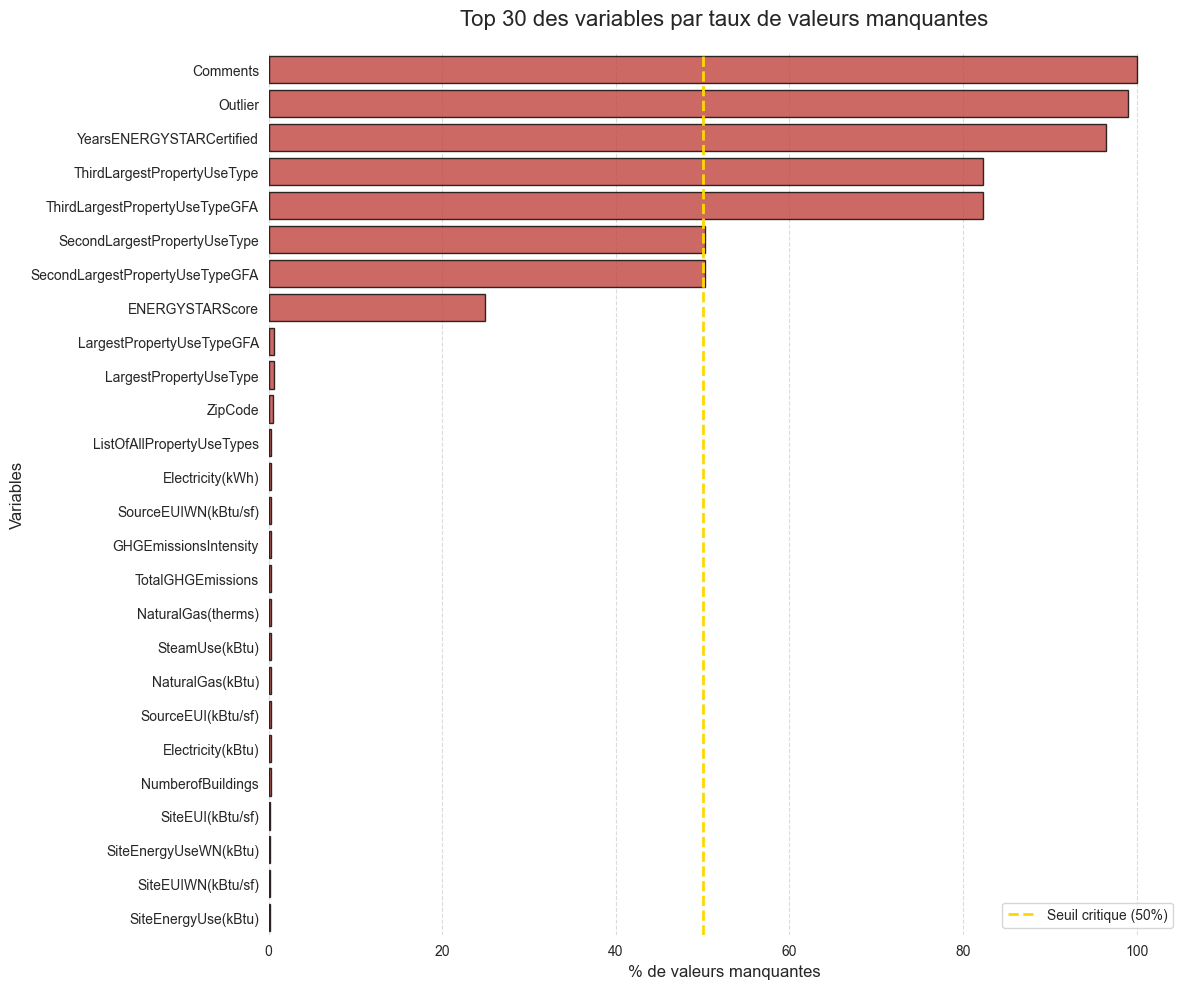

2026-01-01 17:02:36,282 - __main__ - INFO - Graphique des NA : ../figures/notebook_1/01_data_NA_bar.png


In [6]:
# Graphique

# Filtrage pour ne garder que les colonnes ayant des valeurs manquantes
missing_data_plot = missing_df[missing_df['% Missing'] > 0].head(30)

# Création du graphique
plt.figure(figsize=(12, 10))
sns.set_style("white")

# 
barplot = sns.barplot(
    data=missing_data_plot, 
    x='% Missing', 
    y='Column', 
    color='#d73027',
    edgecolor='black',
    alpha=0.8
)

# Ajout d'une ligne de seuil à 50% 
plt.axvline(x=50, color='gold', linestyle='--', linewidth=2, label='Seuil critique (50%)')

# Personnalisation
plt.title('Top 30 des variables par taux de valeurs manquantes', fontsize=16, pad=20)
plt.xlabel('% de valeurs manquantes', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.legend(loc='lower right', frameon=True)

# Ajout d'une grille légère sur l'axe X uniquement
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)

# Exportation du graphique
plt.tight_layout()
plt.savefig('../figures/notebook_1/01_data_NA_bar.png', dpi=300, bbox_inches='tight')
plt.show()

logger.info("Graphique des NA : ../figures/notebook_1/01_data_NA_bar.png")

## Visualisation : Heatmap de missingness

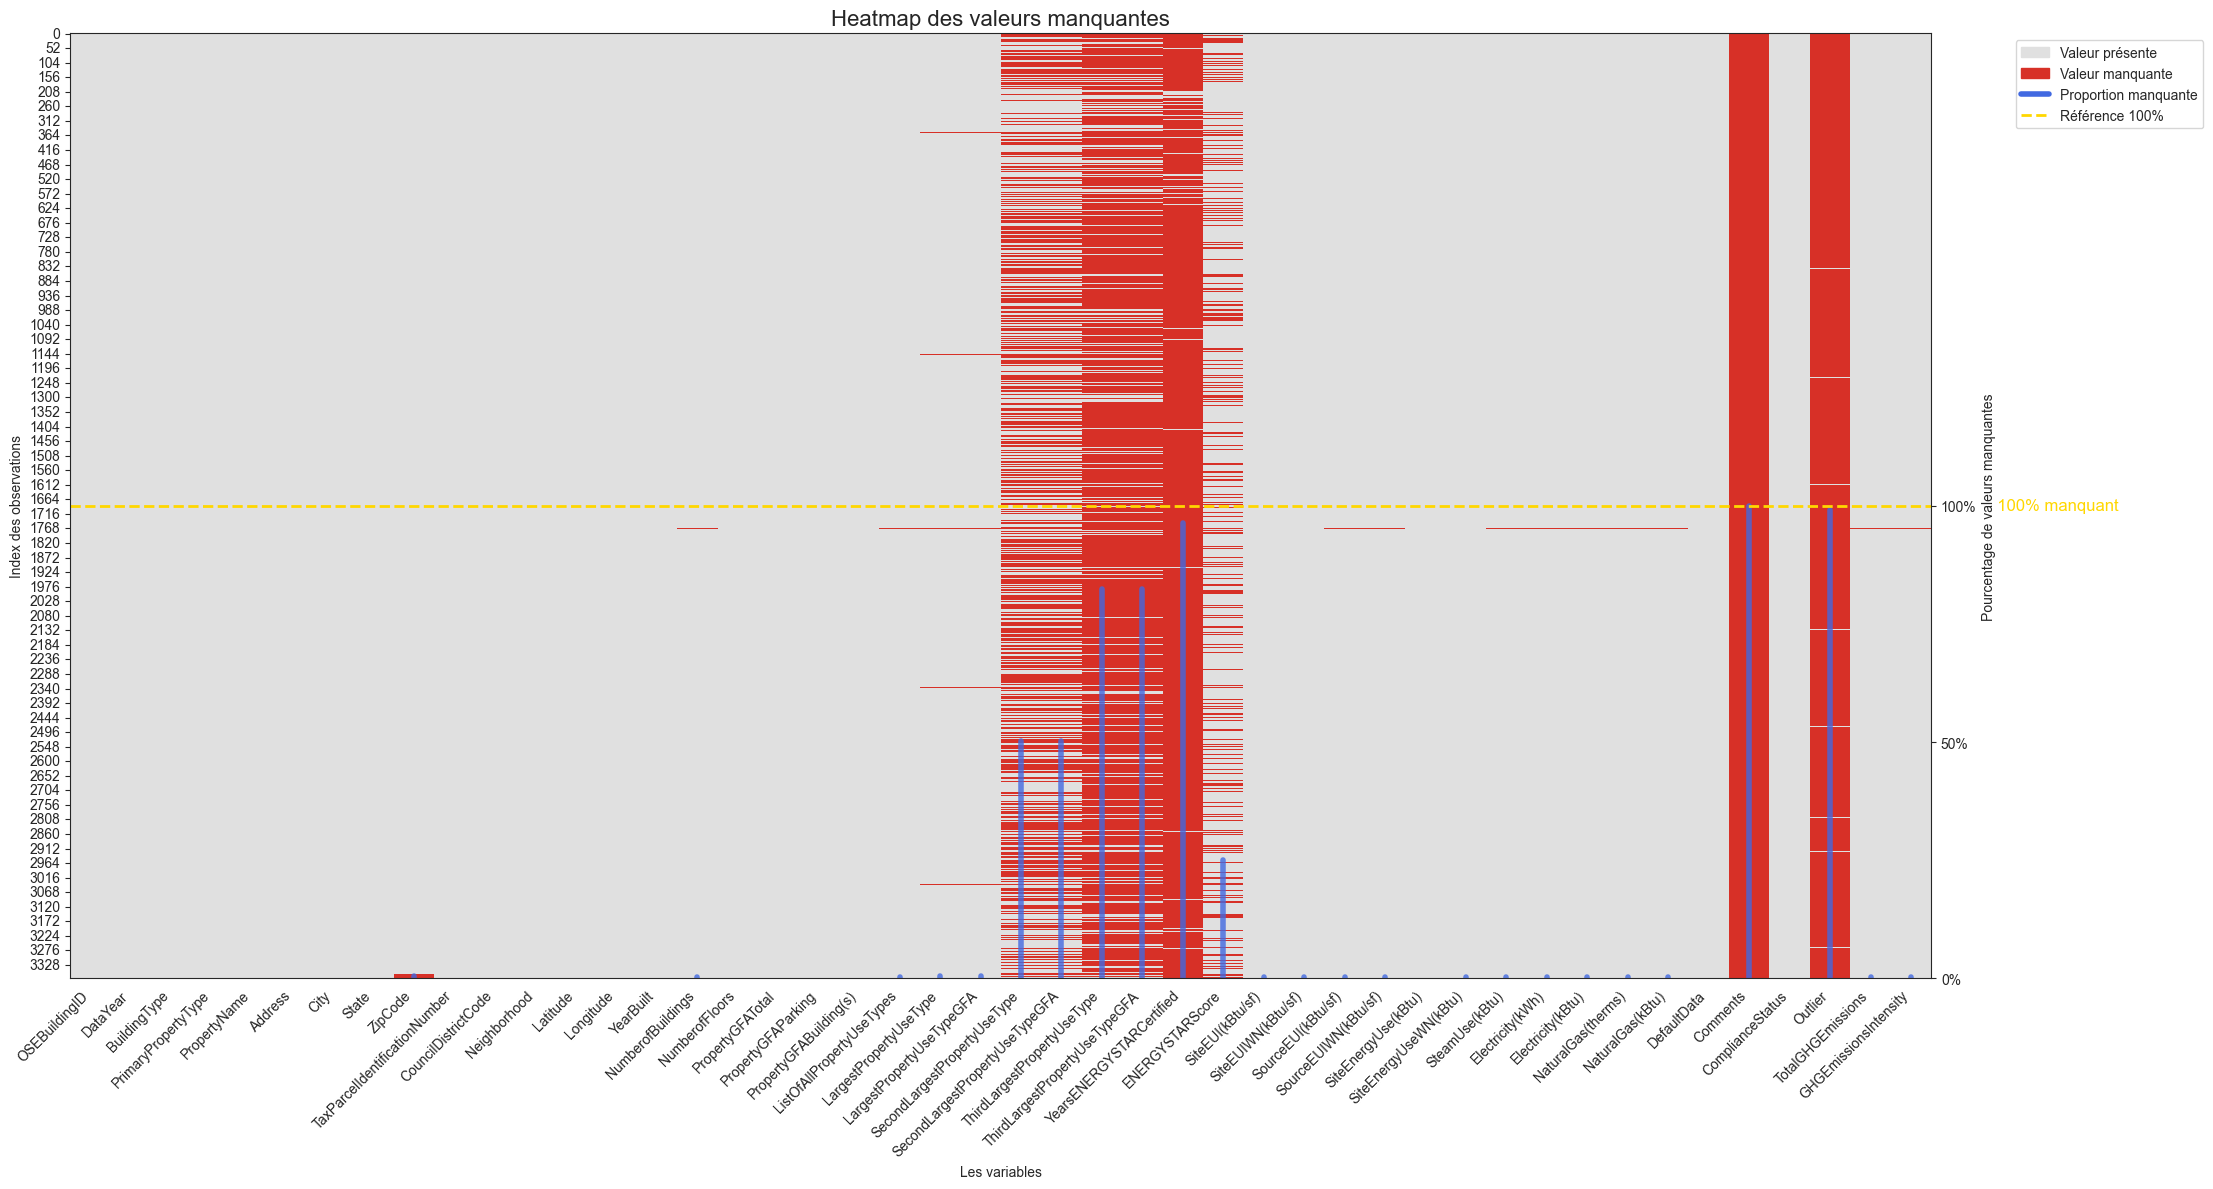

In [7]:

# Calcul du pourcentage de valeurs manquantes par colonne
missing_ratio = df_raw.isnull().mean()

plt.figure(figsize=(22, 12))

# Heatmap binaire
ax = sns.heatmap(df_raw.isnull(),
                 cbar=False,
                 cmap=['#e0e0e0', '#d73027'])  # gris = présent, rouge = manquant

# Titre et axes
plt.title('Heatmap des valeurs manquantes', fontsize=16)
plt.xlabel("Les variables")
plt.ylabel("Index des observations")
plt.xticks(rotation=45, ha='right')

# Ajout des barres verticales
n_rows = len(df_raw)
for i, ratio in enumerate(missing_ratio):
    bar_height = ratio * (n_rows * 0.5)  # 100% correspond à la moitié de l'axe
    ax.plot([i+0.5, i+0.5],
            [n_rows, n_rows - bar_height],
            color='royalblue', linewidth=4, alpha=0.8)

# Ligne jaune pour indiquer la barre des 100% manquants
ax.axhline(y=n_rows - n_rows*0.5, color='gold', linestyle='--', linewidth=2)
ax.text(len(missing_ratio)+0.5, n_rows - n_rows*0.5, "          100% manquant", 
        color='gold', va='center', fontsize=12)

# Axe des pourcentages à gauche
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel("Pourcentage de valeurs manquantes")
ax2.set_yticks([n_rows, n_rows - n_rows*0.25, n_rows - n_rows*0.5])
ax2.set_yticklabels(["0%", "50%", "100%"])

# Légende 
present_patch = mpatches.Patch(color='#e0e0e0', label='Valeur présente')
missing_patch = mpatches.Patch(color='#d73027', label='Valeur manquante')
line_patch = Line2D([0], [0], color='royalblue', linewidth=4, label='Proportion manquante')
ref_patch = Line2D([0], [0], color='gold', linestyle='--', linewidth=2, label='Référence 100%')
plt.legend(handles=[present_patch, missing_patch, line_patch, ref_patch],
           loc='upper right',
           bbox_to_anchor=(1.15, 1),
           frameon=True)

plt.tight_layout()
plt.savefig('../figures/notebook_1/02_quality_missing_heatmap.png',
            dpi=300, bbox_inches='tight')
plt.show()


Même observations que précédement

## Analyse diagnostique des mécanismes de données manquantes par colonne

L'objectif de cette section est de déterminer le mécanisme sous-jacent (MCAR, MAR ou MNAR) afin de choisir la stratégie de traitement appropriée. Selon la littérature, nous distinguons trois mécanismes fondamentaux :

- MCAR (Missing Completely At Random) : La probabilité qu'une donnée manque est indépendante de toute valeur, observée ou non. La suppression n'introduit pas de biais.

- MAR (Missing At Random) : L'absence dépend de variables observées. Exemple : Les bâtiments anciens (YearBuilt) rapportent moins souvent leur score Energy Star. L'imputation multiple est ici recommandée.

- MNAR (Missing Not At Random) : L'absence dépend de la valeur manquante elle-même. Exemple : Un propriétaire ne déclare pas sa consommation car elle est anormalement élevée. Ce cas est le plus complexe et nécessite souvent une modélisation spécifique.
Source :https://bookdown.org/mike/data_analysis/diagnosing-the-missing-data-mechanism.html

### Matrice de corrélation

Nous utilisons d'abord une matrice de corrélation pour identifier les dépendances structurelles (variables qui manquent systématiquement ensemble).

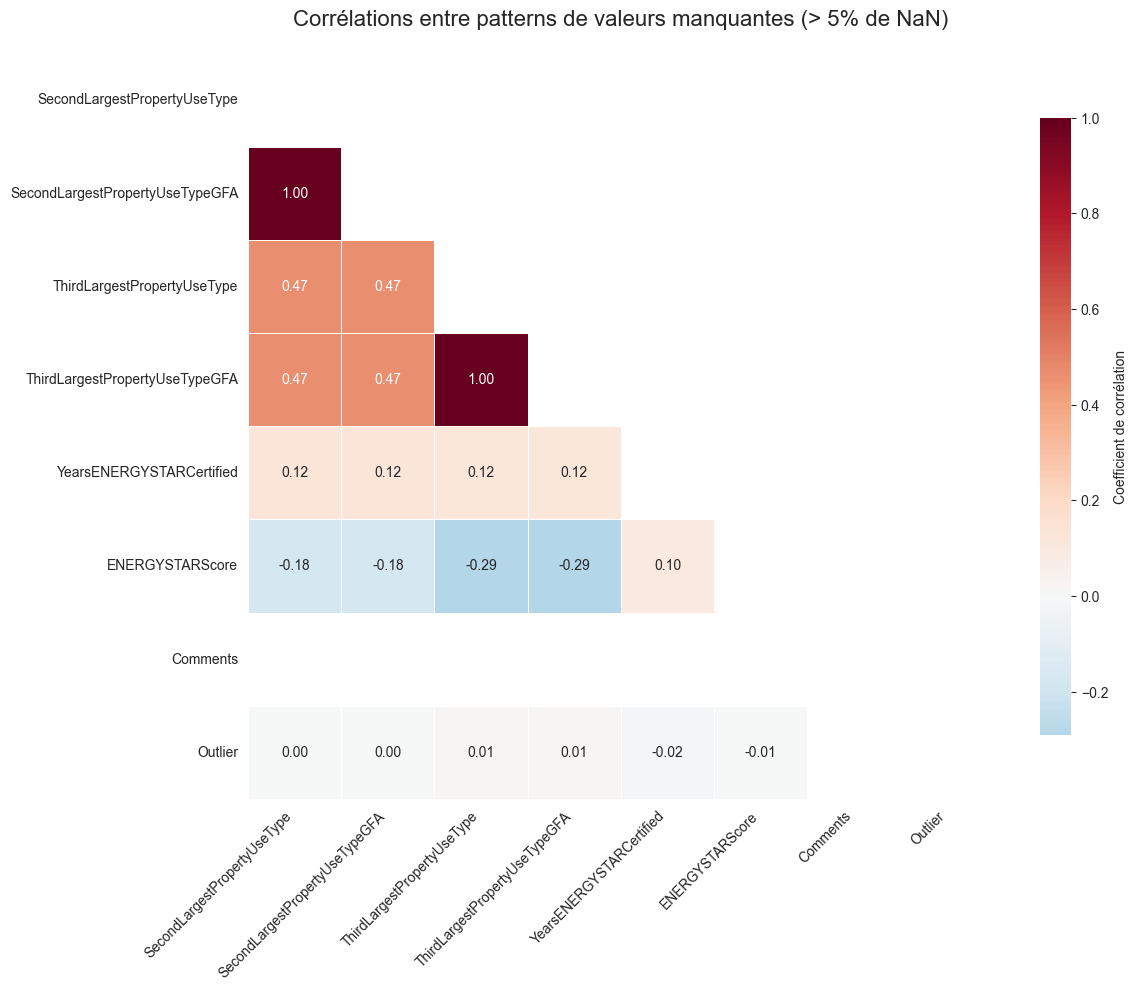

In [8]:
# Sélection des colonnes ayant plus de 5% de valeurs manquantes
threshold = 0.05
missing_rates = df_raw.isnull().mean()
cols_with_missing = missing_rates[missing_rates > threshold].index.tolist()

if len(cols_with_missing) > 1: # Afin de pouvoir tester differents valeurs de threshold
    # Calcul de la corrélation
    missing_corr = df_raw[cols_with_missing].isnull().corr()

    # Masque triangulaire pour la lisibilité
    mask = np.triu(np.ones_like(missing_corr, dtype=bool))

    plt.figure(figsize=(12, 10))

    # RdBu_r : Rouge pour corrélation positive , Bleu pour négative
    sns.heatmap(missing_corr,
                cmap='RdBu_r', 
                center=0,
                annot=True,
                fmt=".2f",
                mask=mask,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8, "label": "Coefficient de corrélation"})

    plt.title('Corrélations entre patterns de valeurs manquantes (> 5% de NaN)', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Exportation
    plt.savefig('../figures/notebook_1/03_quality_missing_corr.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Pas assez de variables significatives pour établir une matrice de corrélation.")

### Interpretation de la matrice de corrélation des valeurs manquantes

Seul 8 variables ont des valeurs manquantes.
#### Tableau des variables à forte NA (> 5%)(Rappel !)

| Colonne | Taux de NaNs | Description | recommandation |
| :--- | :--- | :--- | :--- |
| **SecondLargestPropertyUseType** | 50% | La deuxième utilisation la plus importante d'une propriété (ex: bureau, magasin de détail) par GFA. | **Conserver avec indicateur binaire** Utile pour segmenter les profils de consommation mixtes.|
| **SecondLargestPropertyUseTypeGFA** | 50.3% | La superficie brute de plancher (SFF) de la deuxième plus grande utilisation de la propriété. | **Conserver avec indicateur binaire** Permet de calculer le ratio de mixité d'usage.|
| **ThirdLargestPropertyUseType** | 82.0% | La troisième utilisation la plus importante d'une propriété par GFA.Concerne une minorité de bâtiments très complexes. | **Suppression envisagée ou Conserver avec indicateur binaire** Le volume de données est trop faible pour être statistiquement significatif. |
| **ThirdLargestPropertyUseTypeGFA** | 82.3% | La superficie brute de plancher (SFF) de la troisième plus grande utilisation de la propriété. |**Suppression envisagée ou Conserver avec indicateur binaire** Risque d'ajouter du bruit au modèle au lieu de l'information.|
| **ENERGYSTARScore** | 25% | Note de 1 à 100 évaluant la performance énergétique globale basée sur des données nationales. |**Priorité d'imputation.** Variable clé à traiter|
| **YearsENERGYSTARCertified** | 96.5% | Années où la propriété a reçu la certification ENERGY STAR. | **Suppression** Trop peu de données exploitables pour l'entraînement d'un modèle. |
| **Comments** | 100% | Commentaires d’un propriétaire ou d’un agent pour situer la consommation énergétique. |**Suppression** Colonne totalement vide et inexploitable pour ce projet. |
| **Outlier** | 99.1% | Indique si une propriété est une valeur aberrante élevée ou faible (O/N). |**Filtrage ponctuel.** Utiliser pour le nettoyage initial puis supprimer avant la modélisation. |
---
#### Analyse
>On peux dégager 4 résultats majeurs de cette matrice :

- Corrélation 100% : On observe une corrélation de 1 entre les paires SecondLargestPropertyUseType / SecondLargestPropertyUseTypeGFA d'une part, et ThirdLargestPropertyUseType / ThirdLargestPropertyUseTypeGFA d'autre part. Ce qui est logique car : si un bâtiment ne possède pas de deuxième ou troisième usage, les deux champs (type et surface) sont systématiquement laissés vides.

- Hiérarchie des usages (Corrélation = 0.47) : Il existe une corrélation modérée de 0.47 entre l'absence d'un second usage et l'absence d'un troisième usage. Cela suggère une structure de données en "entonnoir" : la grande majorité des bâtiments ayant un troisième usage ont obligatoirement un second usage renseigné, mais l'inverse n'est pas vrai. La probabilité qu'une donnée soit manquante pour le troisième usage augmente si elle l'est déjà pour le second.

- Indépendance du Score ENERGY STAR : La variable ENERGYSTARScore présente des corrélations très faibles, voire légèrement négatives (ex: -0.29 avec les troisièmes usages), avec les autres variables manquantes. Cela indique que l'absence du score ENERGY STAR ne dépend pas de la complexité de l'usage du bâtiment (nombre d'usages secondaires), mais probablement d'autres facteurs comme l'inéligibilité du type de bâtiment ou l'ancienneté de la construction.

- Variables à valeur manquantes quasi-totale : Les colonnes Comments et Outlier apparaissent déconnectées du reste de la matrice. Comme indiqué dans le dictionnaire de données, ces colonnes sont vides à plus de 99%. Leur présence dans cette matrice confirme qu'elles ne suivent aucun pattern lié aux autres données manquantes ;à supprimmer sans hesitation.


---

### Synthèse du diagnostic par colonne
L'analyse de la matrice révèle deux types de comportements :
1. **Manquants Structurels (Logiques) :** Les usages secondaires et tertiaires. Leur absence est corrélée à 100%, confirmant qu'il ne s'agit pas d'un défaut de collecte mais d'une caractéristique physique du bâtiment (usage unique).
2. **Manquants Potentiellement Biaisés :** Le `ENERGYSTARScore` (25% de NaN) ne semble corrélé à aucune autre absence. 


---
### Problématique:
- **Cas MCAR (Missing Completely At Random)** :  
  Si le score ENERGY STAR manque de manière totalement aléatoire, nous pouvons supprimer les lignes ou appliquer une imputation simple sans introduire de biais majeur.

- **Cas MAR (Missing At Random)** :  
  Si l'absence du score est liée à une variable observée (par exemple le type de bâtiment, la certification ou la taille), alors une suppression naïve introduirait un biais. Dans ce cas, il faut envisager des méthodes d’imputation conditionnelles.

- **Cas MNAR (Missing Not At Random)** :  
  Si le score manque parce que la valeur elle-même est problématique (par exemple, les bâtiments très énergivores ne déclarent pas leur score), alors l’absence est informative. Il faut adapter l’analyse : création d’indicateurs de "valeur manquante", modèles spécifiques, ou acceptation de limites dans l’interprétation.

---

### Conclusion
Avant de traiter les valeurs manquantes, il est indispensable de tester la dépendance entre l’absence du `ENERGYSTARScore` et les autres variables.  
- Si l’absence est aléatoire (MCAR), une suppression est envisageable.  
- Si elle est conditionnelle (MAR), une imputation basée sur les variables corrélées est nécessaire.  
- Si elle est non aléatoire (MNAR), l’absence elle-même devient une information à intégrer dans le modèle.  


### Test du mécanisme MAR

Pour diagnostiquer si nous sommes en présence d'un mécanisme MAR, nous vérifions si l'absence du ENERGYSTARScore est corrélée au type de bâtiment(pertinent pour des raison de comprehension métier). Si la distribution des manquants varie selon le BuildingType, cela prouve que l'absence est conditionnelle et non aléatoire.

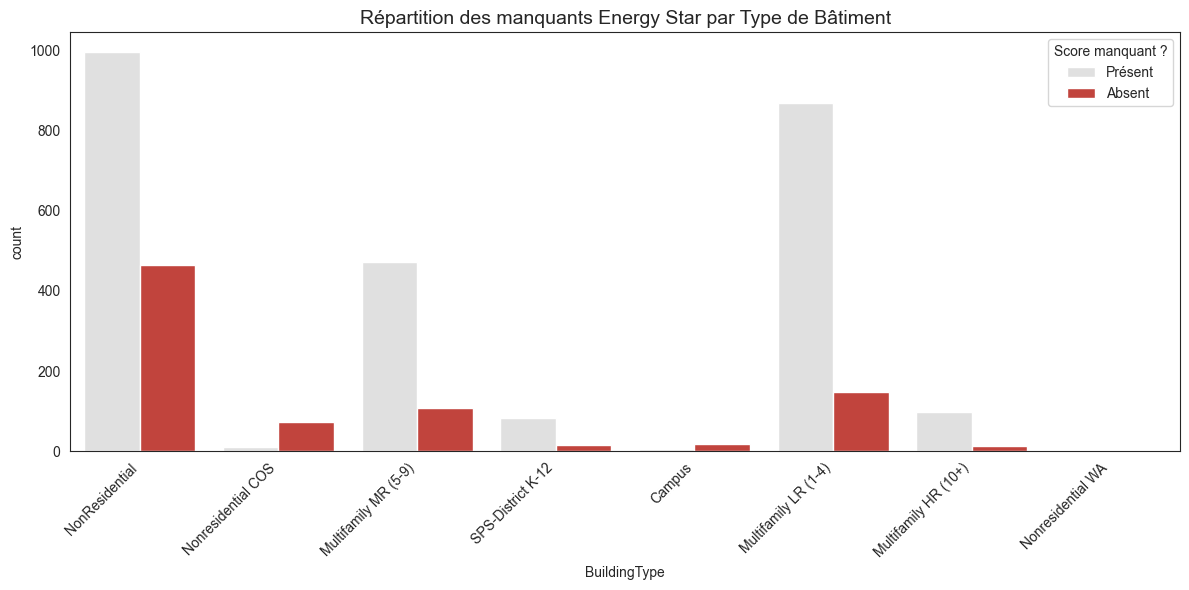

2026-01-01 17:02:40,768 - __main__ - INFO - Test du Chi² - p-value: 3.3275e-69


Résultat du test du Chi² : p-value = 3.3275e-69


In [9]:
# Préparation des données
df_raw['ENERGYSTARScore_is_missing'] = df_raw['ENERGYSTARScore'].isnull()

# Visualisation
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_raw, x='BuildingType', hue='ENERGYSTARScore_is_missing', palette=['#e0e0e0', '#d73027'])
plt.title('Répartition des manquants Energy Star par Type de Bâtiment', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Score manquant ?', labels=['Présent', 'Absent'])
plt.tight_layout()
plt.savefig('../figures/notebook_1/03_energystar_missing_by_buildingtype.png')
plt.show()

# Test Statistique du Chi2
contingency_table = pd.crosstab(df_raw['BuildingType'], df_raw['ENERGYSTARScore_is_missing'])
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

logger.info(f"Test du Chi² - p-value: {p_val:.4e}")
print(f"Résultat du test du Chi² : p-value = {p_val:.4e}")

---

### Conclusion
L’analyse graphique montre que l’absence du score ENERGY STAR n’est pas répartie uniformément entre les types de bâtiments. Certaines catégories, comme les bâtiments non résidentiels ou les petits immeubles résidentiels multifamiliaux, présentent une proportion plus élevée de valeurs manquantes, tandis que d’autres sont relativement peu affectés. Cette hétérogénéité suggère que le mécanisme de données manquantes n’est pas complètement aléatoire.

Le test du Chi2 confirme cette observation : la p-value obtenue (≈ 3.3e-69) rejette l’hypothèse d’indépendance entre le type de bâtiment et la présence du score. On peut donc conclure que la probabilité qu’un score soit manquant dépend significativement de variables observées, en particulier du type de bâtiment.

Il est important de noter que ce résultat permet uniquement d’écarter l’hypothèse MCAR (Missing Completely At Random). L’hypothèse MAR (Missing At Random) reste une hypothèse de travail plausible, dans la mesure où la manquance semble liée à des covariables observées, mais elle ne peut pas être prouvée directement. En revanche, supposer MAR est raisonnable pour appliquer des méthodes d’imputation conditionnelles.

### Implication:
- La suppression naïve des lignes avec score manquant introduirait un biais structurel, car la manquance est corrélée au type de bâtiment.
- Il est préférable d’utiliser des méthodes d’imputation conditionnelles (par exemple en tenant compte de BuildingType et YearBuilt) ou de créer un indicateur ENERGYSTARScore_Available afin d’intégrer explicitement l’information de manquance dans les modèles.


## Analyse des lignes avec taux élevé de NA

Après avoir diagnostiqué les variables, nous examinons si certains bâtiments présentent un déficit de données tel qu'ils pourraient nuire à la fiabilité de nos futurs modèles. Une ligne avec trop de valeurs manquantes est souvent le signe d'un défaut majeur lors de la déclaration

In [10]:
# Calcul du % de NA par ligne
row_missing_pct = df_raw.isnull().mean(axis=1) * 100

# Statistiques descriptives
print(" ANALYSE DES LIGNES PAR TAUX DE NA")
print("="*70)
print(f"Moyenne : {row_missing_pct.mean():.2f}%")
print(f"Médiane : {row_missing_pct.median():.2f}%")
print(f"Q1 (25%) : {row_missing_pct.quantile(0.25):.2f}%")
print(f"Q3 (75%) : {row_missing_pct.quantile(0.75):.2f}%")
print(f"Max : {row_missing_pct.max():.2f}%")
print()

# Comptage par seuil
thresholds = [10, 20, 30, 50]
for t in thresholds:
    n_above = (row_missing_pct > t).sum()
    pct_above = n_above / len(df_raw) * 100
    print(f"Lignes avec >{t}% NA : {n_above:,} ({pct_above:.2f}%)")

 ANALYSE DES LIGNES PAR TAUX DE NA
Moyenne : 12.57%
Médiane : 12.77%
Q1 (25%) : 10.64%
Q3 (75%) : 14.89%
Max : 53.19%

Lignes avec >10% NA : 2,733 (80.95%)
Lignes avec >20% NA : 13 (0.39%)
Lignes avec >30% NA : 9 (0.27%)
Lignes avec >50% NA : 5 (0.15%)


### Résumé  
La majorité des lignes présentent un taux de valeurs manquantes modéré autour de 10–15 %, avec une médiane à 12,8 %. Seules quelques lignes isolées dépassent 30 %, et moins de 1 % atteignent des niveaux critiques au-delà de 50 %.  


In [11]:
rows_between_30_50 = df_raw[(row_missing_pct > 30) & (row_missing_pct <= 50)]
print("Lignes avec entre 30% et 50% de NA :")
display(rows_between_30_50)

rows_above_50 = df_raw[row_missing_pct > 50]
print("Lignes avec plus de 50% de NA :")
display(rows_above_50)





Lignes avec entre 30% et 50% de NA :


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,ENERGYSTARScore_is_missing
1768,23355,2016,Multifamily LR (1-4),Low-Rise Multifamily,GRAHAM VIEW,6040 CALIFORNIA AVE SW,Seattle,WA,98136.0,7625703280,1,SOUTHWEST,47.54731,-122.38656,1992,NaN,4,29357,0,29357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.200001,20.200001,NaN,NaN,5.636832e+05,5.937986e+05,NaN,NaN,NaN,NaN,NaN,False,NaN,Compliant,NaN,NaN,NaN,True
2321,25431,2016,Multifamily LR (1-4),Low-Rise Multifamily,PONDERAY APTS,5625 15TH AVE NE,Seattle,WA,98105.0,5226300030,4,NORTHEAST,47.67025,-122.31232,1963,NaN,4,28472,0,28472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.100000,28.000000,NaN,NaN,7.702755e+05,7.975070e+05,NaN,NaN,NaN,NaN,NaN,False,NaN,Compliant,NaN,NaN,NaN,True
2480,25763,2016,Multifamily LR (1-4),Low-Rise Multifamily,Villa Andora,1520 CALIFORNIA AVE SW,Seattle,WA,98116.0,9272201340,1,SOUTHWEST,47.58968,-122.38587,1969,NaN,3,30420,0,30420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.500000,37.000000,NaN,NaN,1.049639e+06,1.126782e+06,NaN,NaN,NaN,NaN,NaN,False,NaN,Compliant,NaN,NaN,NaN,True
3348,50082,2016,Multifamily LR (1-4),Low-Rise Multifamily,STREAM FIFTEEN,605 15TH AVE E,Seattle,WA,98112.0,3303700030,3,EAST,47.62441,-122.31300,2015,1.0,4,36685,8254,28431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.100000,31.500000,NaN,NaN,8.202201e+05,8.576127e+05,NaN,NaN,NaN,NaN,NaN,False,NaN,Compliant,NaN,NaN,NaN,True


Lignes avec plus de 50% de NA :


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,ENERGYSTARScore_is_missing
578,773,2016,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,215 COLUMBIA ST,Seattle,WA,98104.0,0939000245,7,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,63150,0,63150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Non-Compliant,NaN,NaN,NaN,True
758,19798,2016,Multifamily LR (1-4),Low-Rise Multifamily,SANDHURST APTS,7239 SAND POINT WAY NE,Seattle,WA,98115.0,0225049032,4,NORTHEAST,47.68149,-122.26471,1977,NaN,3,33166,0,33166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Non-Compliant,NaN,NaN,NaN,True
1792,23437,2016,Multifamily LR (1-4),Low-Rise Multifamily,MERCER CREST APT,500 W MERCER ST,Seattle,WA,98119.0,3876900230,7,MAGNOLIA / QUEEN ANNE,47.62479,-122.36364,1957,NaN,4,23636,0,23636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Non-Compliant,NaN,NaN,NaN,True
2474,25752,2016,Multifamily LR (1-4),Low-Rise Multifamily,GRANVIEW APARTMENTS,1120 N 93RD ST,Seattle,WA,98103.0,9267200155,6,NORTHWEST,47.69658,-122.34342,1989,NaN,4,29562,8531,21031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Non-Compliant,NaN,NaN,NaN,True
2670,26532,2016,NonResidential,Mixed Use Property,KALBERG BUILDING,4515 UNIVERSITY WAY NE,Seattle,WA,98105.0,8816401120,4,NORTHEAST,47.66182,-122.31345,1928,NaN,2,20760,0,20760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Non-Compliant,NaN,NaN,NaN,True


### Verdict
- 30 à  50%de NA :Ces lignes concernent des bâtiments résidentiels multifamiliaux. Elles disposent d’informations de localisation et de surfaces, mais manquent de données sur les usages, les consommations énergétiques et les indicateurs environnementaux. Leur statut est Compliant, ce qui signifie qu’elles ont été déclarées mais de manière incomplète.
- Plus de 50% de NA :Ces lignes regroupent des bâtiments résidentiels et non résidentiels. Elles conservent les informations de base (adresse, surfaces, année de construction), mais les variables énergétiques et environnementales sont totalement absentes. Leur statut est Non-Compliant, ce qui confirme qu’elles n’ont pas respecté les exigences de reporting.
>Décision : On drop toutes les lignes avec >30% de NA.
>on garde les lignes entre 20 et 30 % de NA, mais on les traite avec une imputation spécifique pour éviter de perdre de l’information tout en limitant le biais.

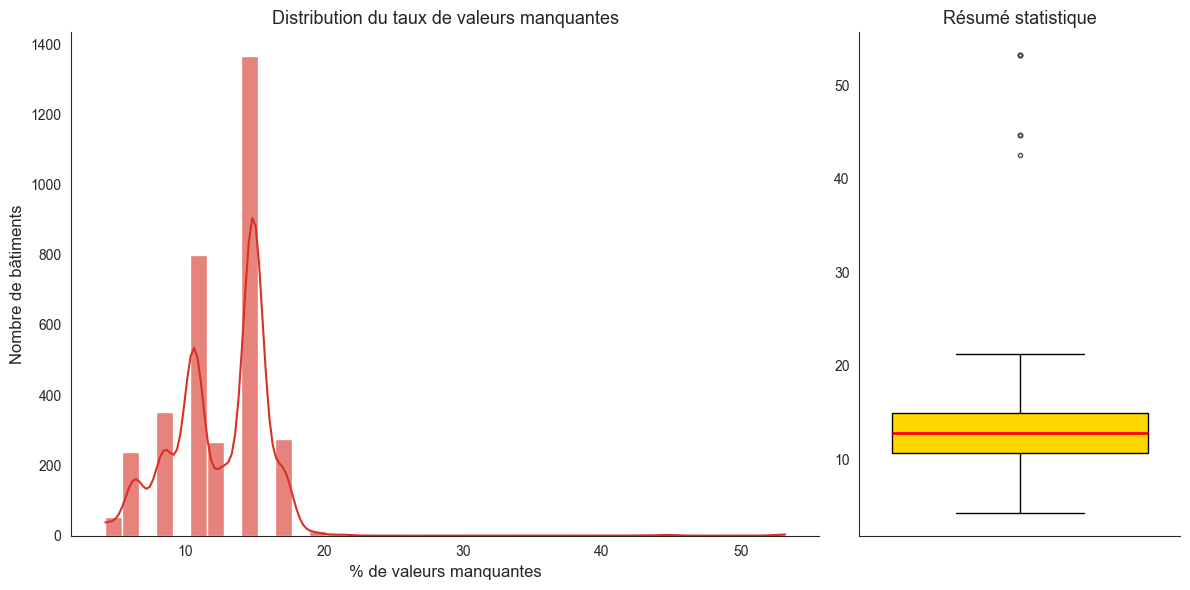

In [12]:
row_missing=row_missing_pct
# Visualisation de la distribution
# figure côte à côte
f, (ax_hist, ax_box) = plt.subplots(
    1, 2,
    figsize=(12, 6),
    gridspec_kw={"width_ratios": (0.7, 0.3)}  
)

# Histogramme à gauche
sns.histplot(row_missing, bins=40, kde=True, color='#d73027', ax=ax_hist, alpha=0.6)
ax_hist.set_xlabel('% de valeurs manquantes', fontsize=12)
ax_hist.set_ylabel('Nombre de bâtiments', fontsize=12)
ax_hist.set_title('Distribution du taux de valeurs manquantes', fontsize=13)

# Boxplot vertical à droite
sns.boxplot(
    y=row_missing, 
    ax=ax_box, 
    color='gold', 
    fliersize=3, 
    medianprops={'color':'red','linewidth':2},
    boxprops={'facecolor':'#FFD700','edgecolor':'black'},
    whiskerprops={'color':'black'},
    capprops={'color':'black'}
)
ax_box.set_title('Résumé statistique', fontsize=13)
ax_box.set(ylabel='')
ax_box.set_xticks([])

# Nettoyage des bordures
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box)

plt.tight_layout()
plt.savefig('../figures/notebook_1/04_data_row_distribution_NA.png', dpi=300, bbox_inches='tight')
plt.show()


La distribution du taux de valeurs manquantes par bâtiment montre une forte concentration autour de 10–15 %, avec la quasi‑totalité des bâtiments en dessous de 20 %.  

L’histogramme met en évidence une asymétrie vers la droite, traduisant l’existence d’un petit sous‑groupe de bâtiments avec des taux de valeurs manquantes nettement plus élevés. La longue traîne confirme que ces cas isolés sont responsables des lacunes les plus importantes.  

Le box‑plot illustre cette situation en synthétisant la distribution : une médiane basse, des quartiles resserrés et quelques outliers bien au‑delà du troisième quartile. Ces valeurs extrêmes correspondent aux bâtiments que nous avons décidé de supprimer ou d’exclure des analyses énergétiques, car leur taux de données manquantes dépasse les seuils retenus.

# Section 2 : Détection et analyse contextuelle des valeurs aberrantes

Initialement, nous avons testé plusieurs méthodes de détection des outliers, notamment le Z-score, le Z-score sur données transformées par logarithme (Log-Z), et l'intervalle interquartile (IQR). Cependant, ces approches globales ont montré des limites significatives (voir les graphiques _audit_indicateurs_ dans figures/notebook_1). En effet, les distributions des données énergétiques présentent des caractéristiques qui rendent ces méthodes peu adaptées : asymétrie marquée, présence de multiples modes après transformation logarithmique, et des valeurs extrêmes qui peuvent être légitimes dans certains contextes.

Pour pallier ces limitations, nous adoptons une approche plus nuancée et contextuelle. L'idée est de segmenter les bâtiments par type (PrimaryPropertyType) afin de détecter des anomalies plus pertinentes.

>Notons que nous disposons d’une colonne Outlier qui recense 32 valeurs aberrantes. Nous l’utiliserons ultérieurement pour analyser nos résultats.

## Choix des variables à auditer

Le dataset comporte des variables hétérogènes, mêlant identifiants, informations descriptives, caractéristiques physiques des bâtiments, indicateurs énergétiques et variables de conformité.
Dans le cadre de cette section consacrée à la détection des valeurs aberrantes, il est nécessaire de restreindre l’analyse à un sous-ensemble de variables quantitatives présentant un sens physique clair et pour lesquelles la notion d’outlier est statistiquement et méthodologiquement pertinente.

Le choix des variables auditées repose sur les principes suivants :

- privilégier les grandeurs physiques mesurées ou dérivées 

- inclure des variables structurantes susceptibles d’expliquer des valeurs extrêmes

- exclure les identifiants, variables textuelles et variables purement catégorielles, pour lesquelles la détection d’outliers n’a pas de signification directe

Notre choix :

- SiteEnergyUse,TotalGHGEmissions,GHGEmissionsIntensity

- Les indicateurs SiteEUI(kBtu/sf) et SourceEUI(kBtu/sf) correspondent à des consommations normalisées par la surface du bâtiment.Contrairement aux consommations totales, ces variables permettent de comparer des bâtiments de tailles différentes sur une base homogène.Des valeurs extrêmes sur ces indicateurs sont particulièrement informatives :elles signalent souvent des erreurs sur la surface (PropertyGFATotal) ou peuvent révéler des incohérences entre énergie déclarée et dimensions du bâtiment. 

- Les Composantes énergétiques : Electricity, NaturalGas, SteamUse. Une anomalie sur l’une de ces composantes se propage mécaniquement vers la consommation totale et les émissions de gaz à effet de serre.

- Les Surfaces: PropertyGFATotal et les sous-surfaces (Largest...). Des surfaces nulles ou gigantesques doivent être validées.Des valeurs aberrantes sur les surfaces (nulles, négatives ou excessivement élevées) ont un impact direct sur l'EUI,la comparabilité entre bâtiments et l'interprétation des performances énergetiques

- ENERGYSTARScore. Bien que borné [0-100], l'IQR permet de voir si la distribution est anormalement écrasée.


In [28]:
df_raw['Outlier'].dropna().shape[0]
#df_raw.loc[df_raw['Outlier'].notna()].head()

32

## Pourquoi analyser les batiments par groupe ?
L'analyse par groupe est essentielle pour plusieurs raisons. Tout d'abord, les données énergétiques des bâtiments présentent souvent des distributions fortement asymétriques, avec une longue traîne de valeurs élevées. Cette asymétrie fausse les résultats des tests statistiques classiques comme le Z-score. Ensuite, après transformation logarithmique, certaines variables révèlent plusieurs modes, ce qui indique que les données ne suivent pas une distribution normale et que les tests paramétriques ne sont pas appropriés.
De plus, un bâtiment peut être un outlier global mais tout à fait normal dans son contexte spécifique. Par exemple, un hôpital peut avoir une consommation énergétique élevée par rapport à l'ensemble des bâtiments, mais être tout à fait normal par rapport à d'autres hôpitaux. En analysant les bâtiments par groupe, nous pouvons détecter des anomalies plus pertinentes et distinguer les erreurs de saisie des variations légitimes.


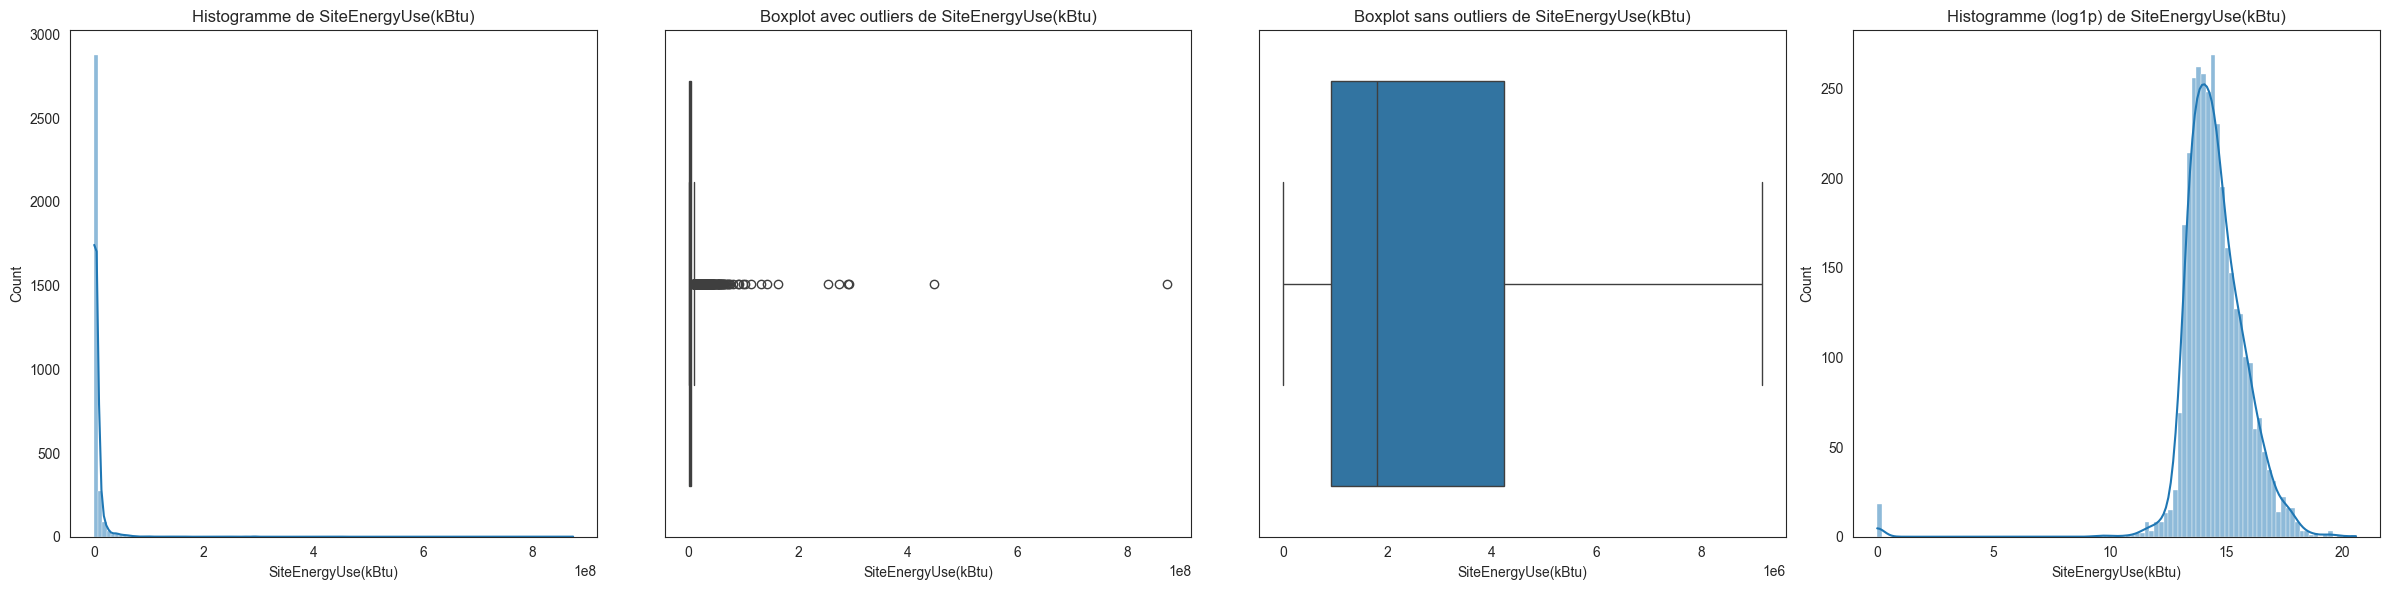

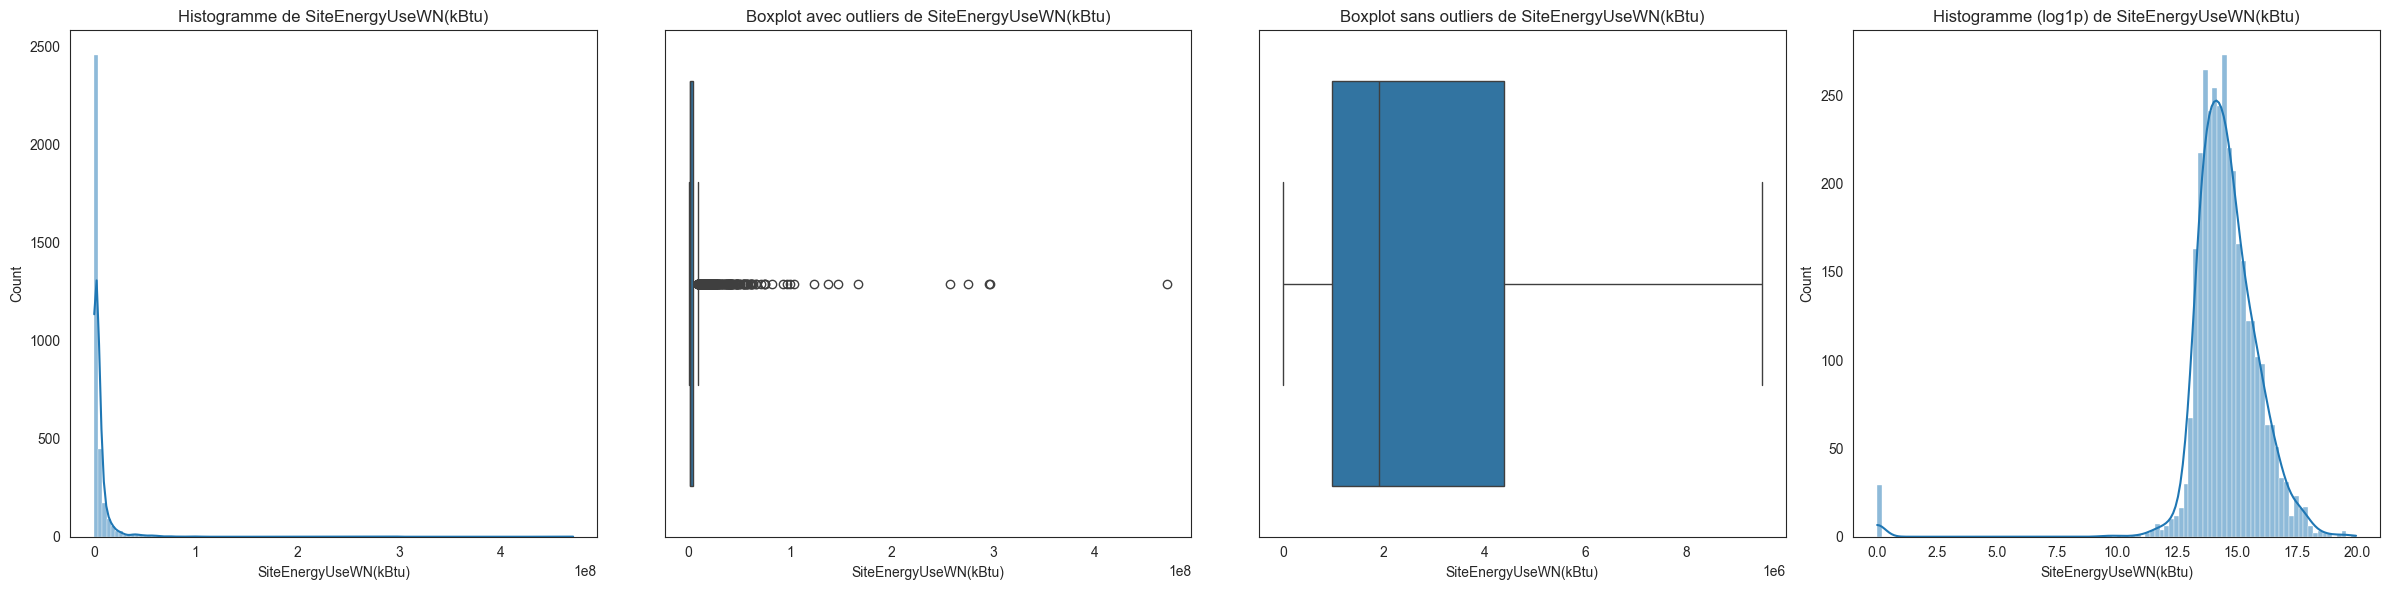

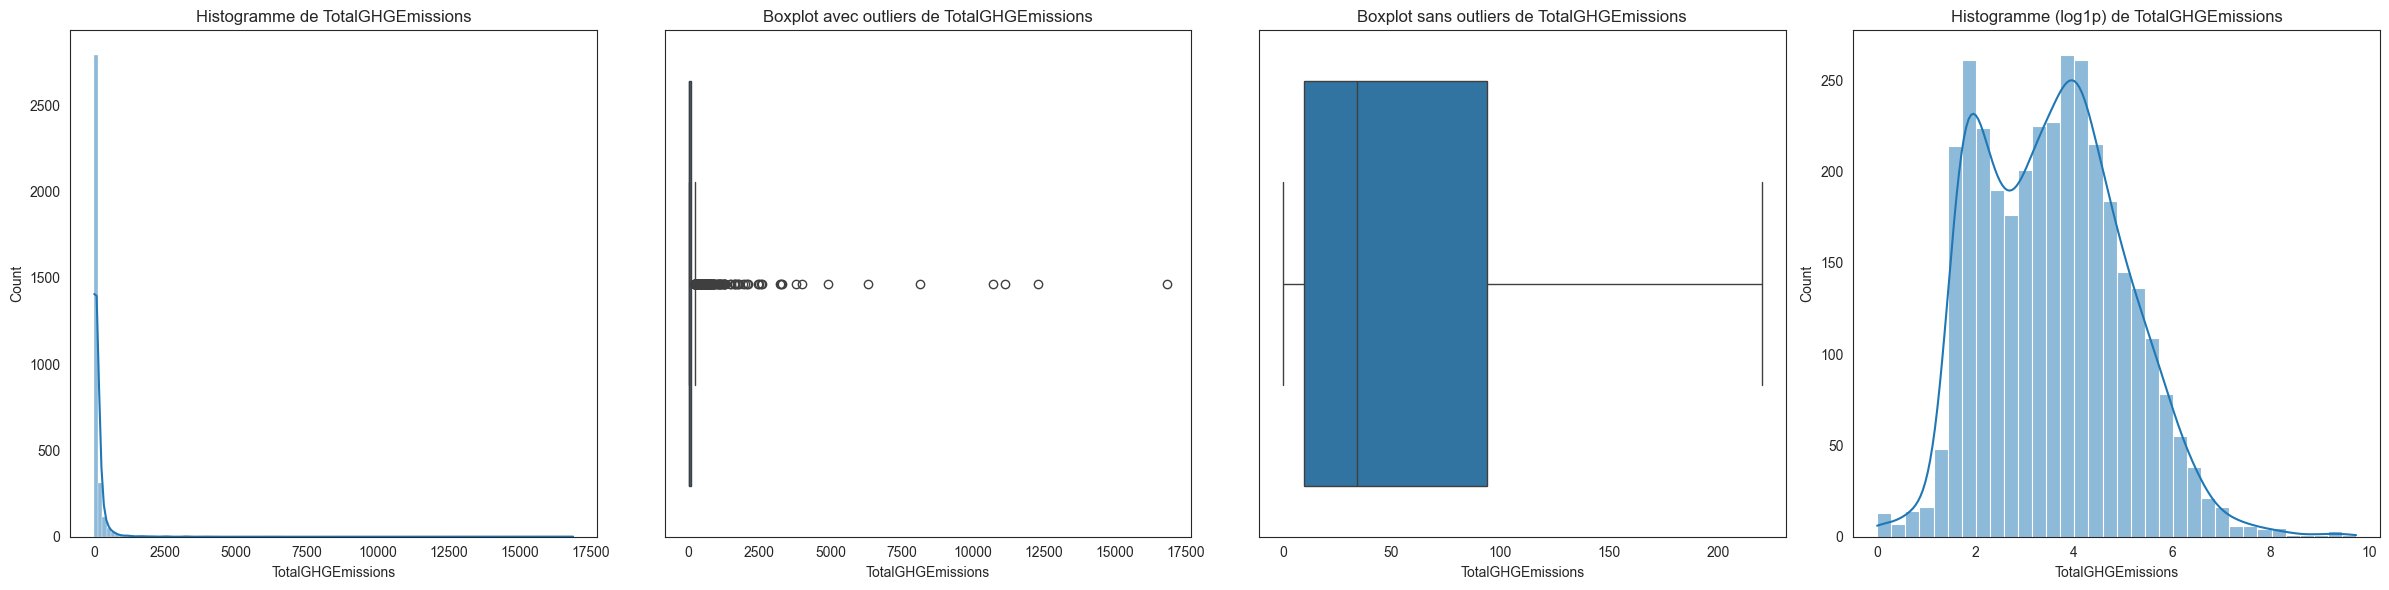

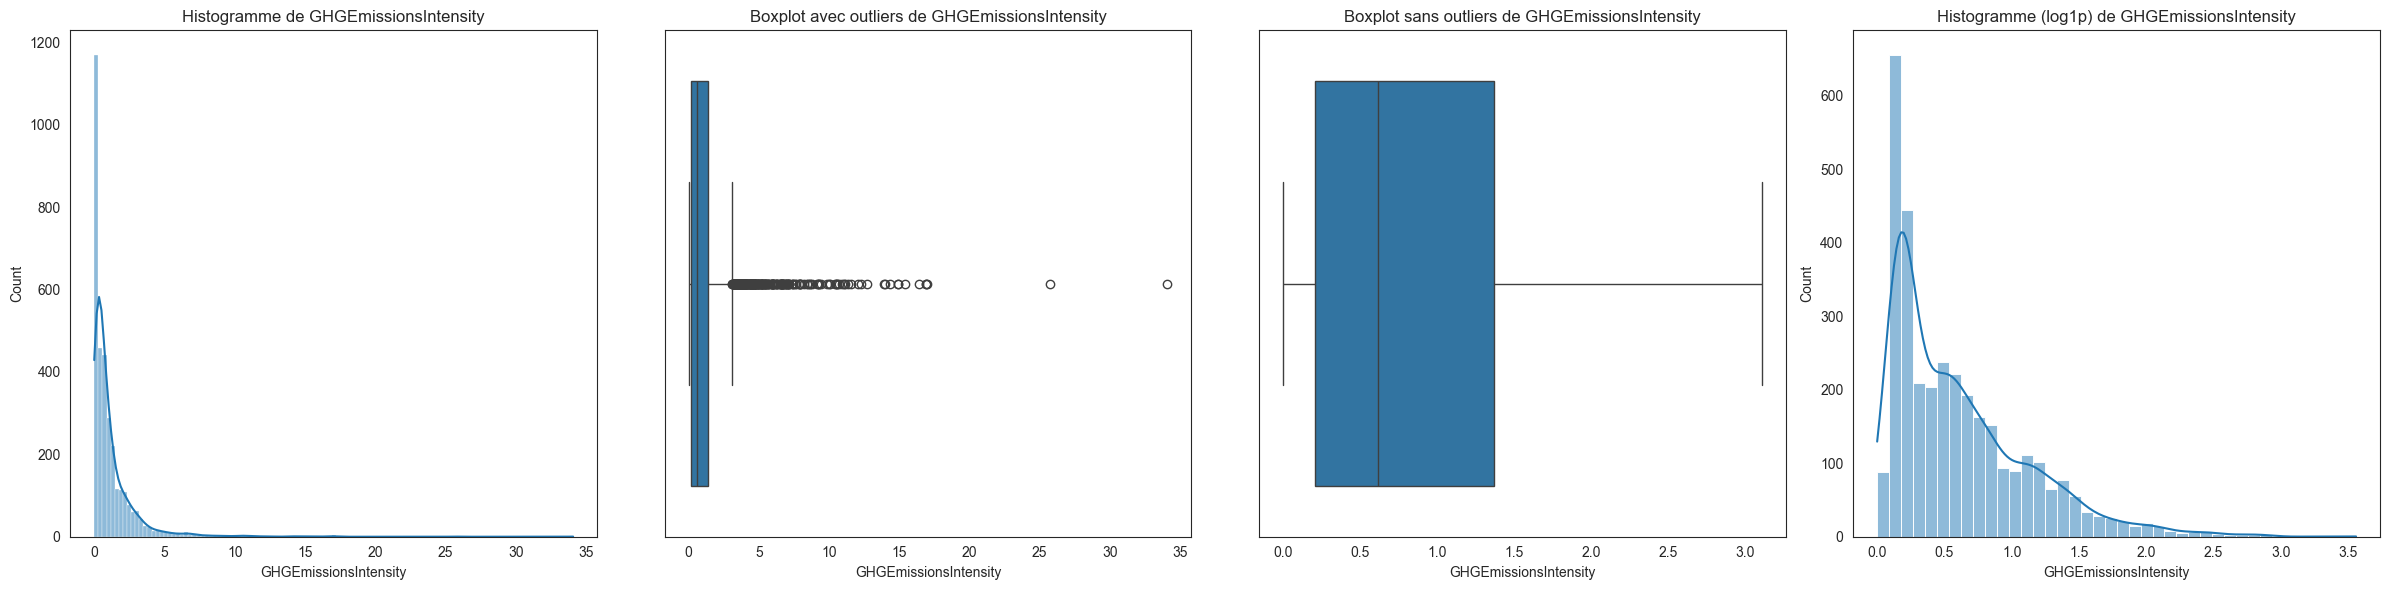

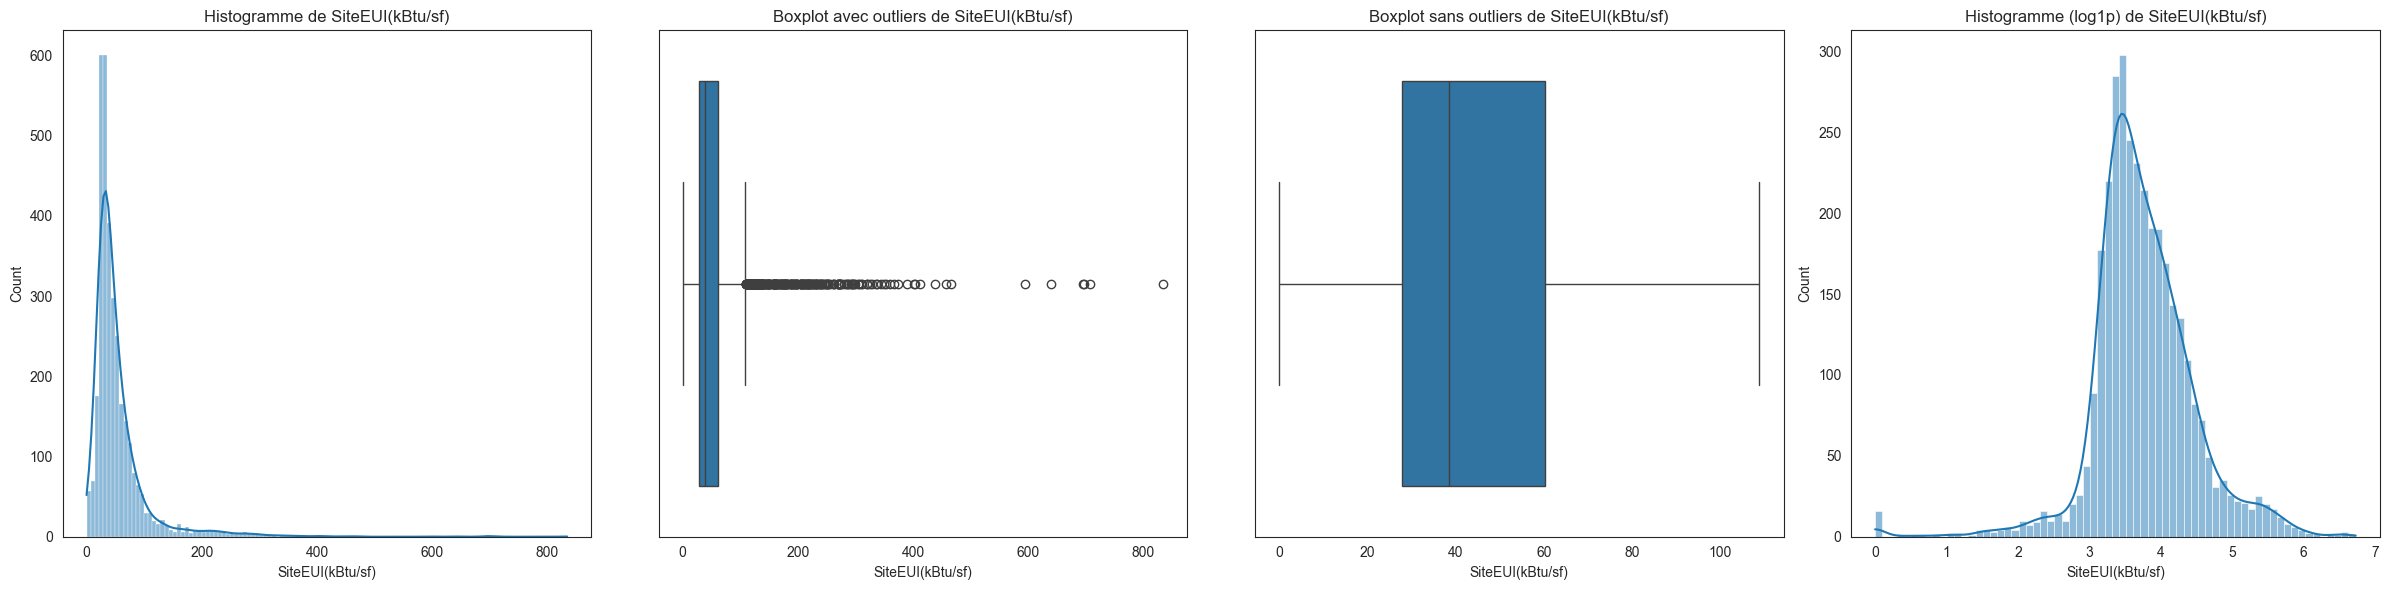

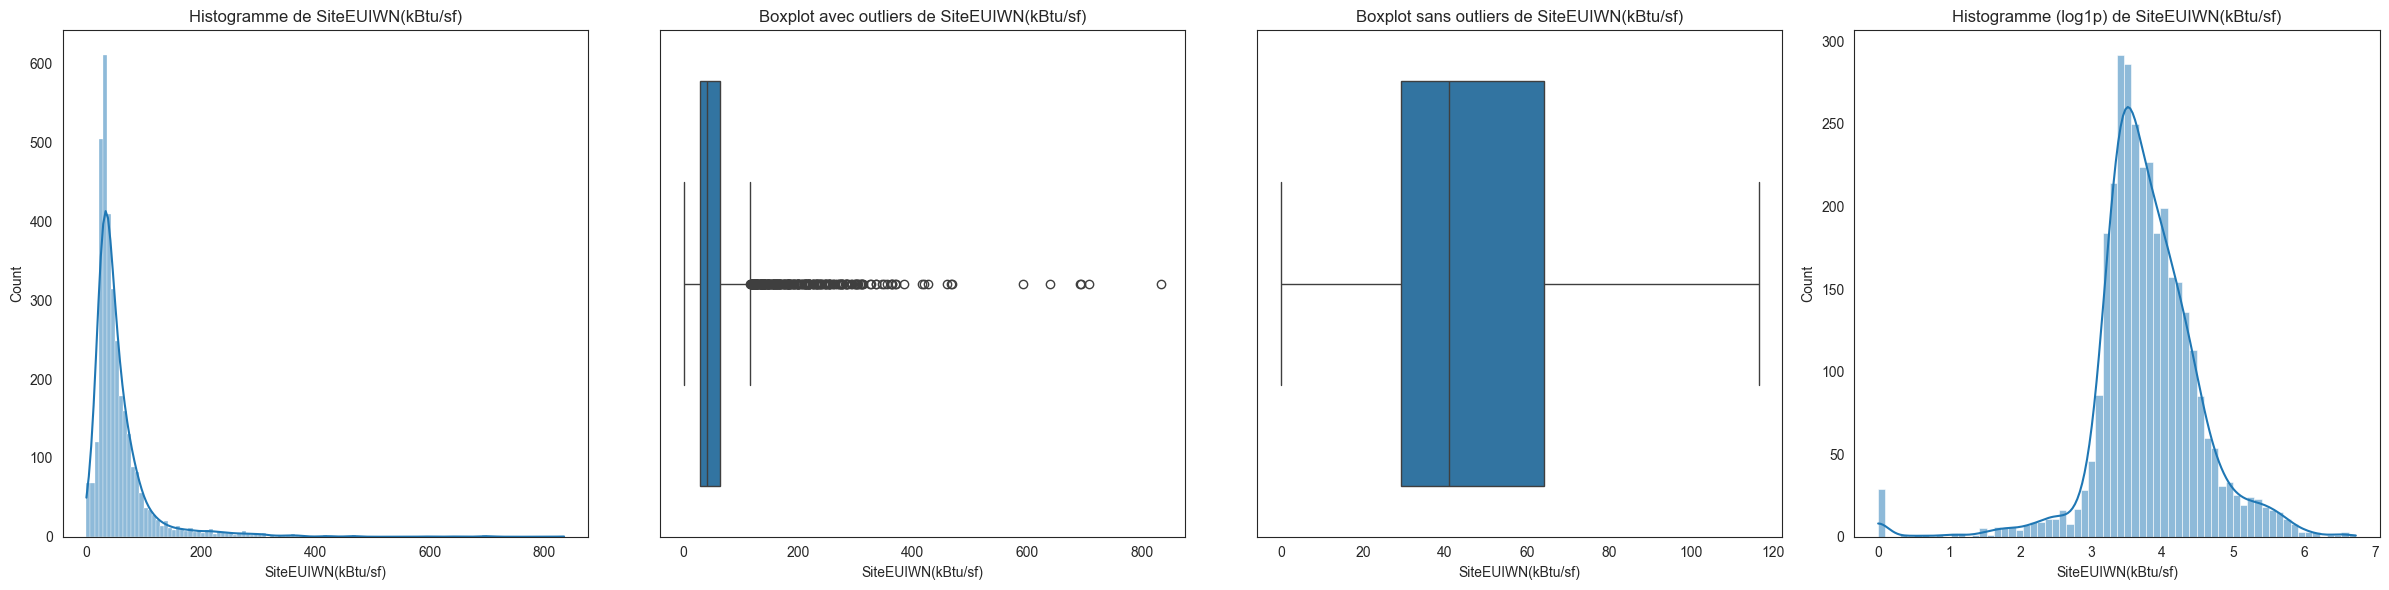

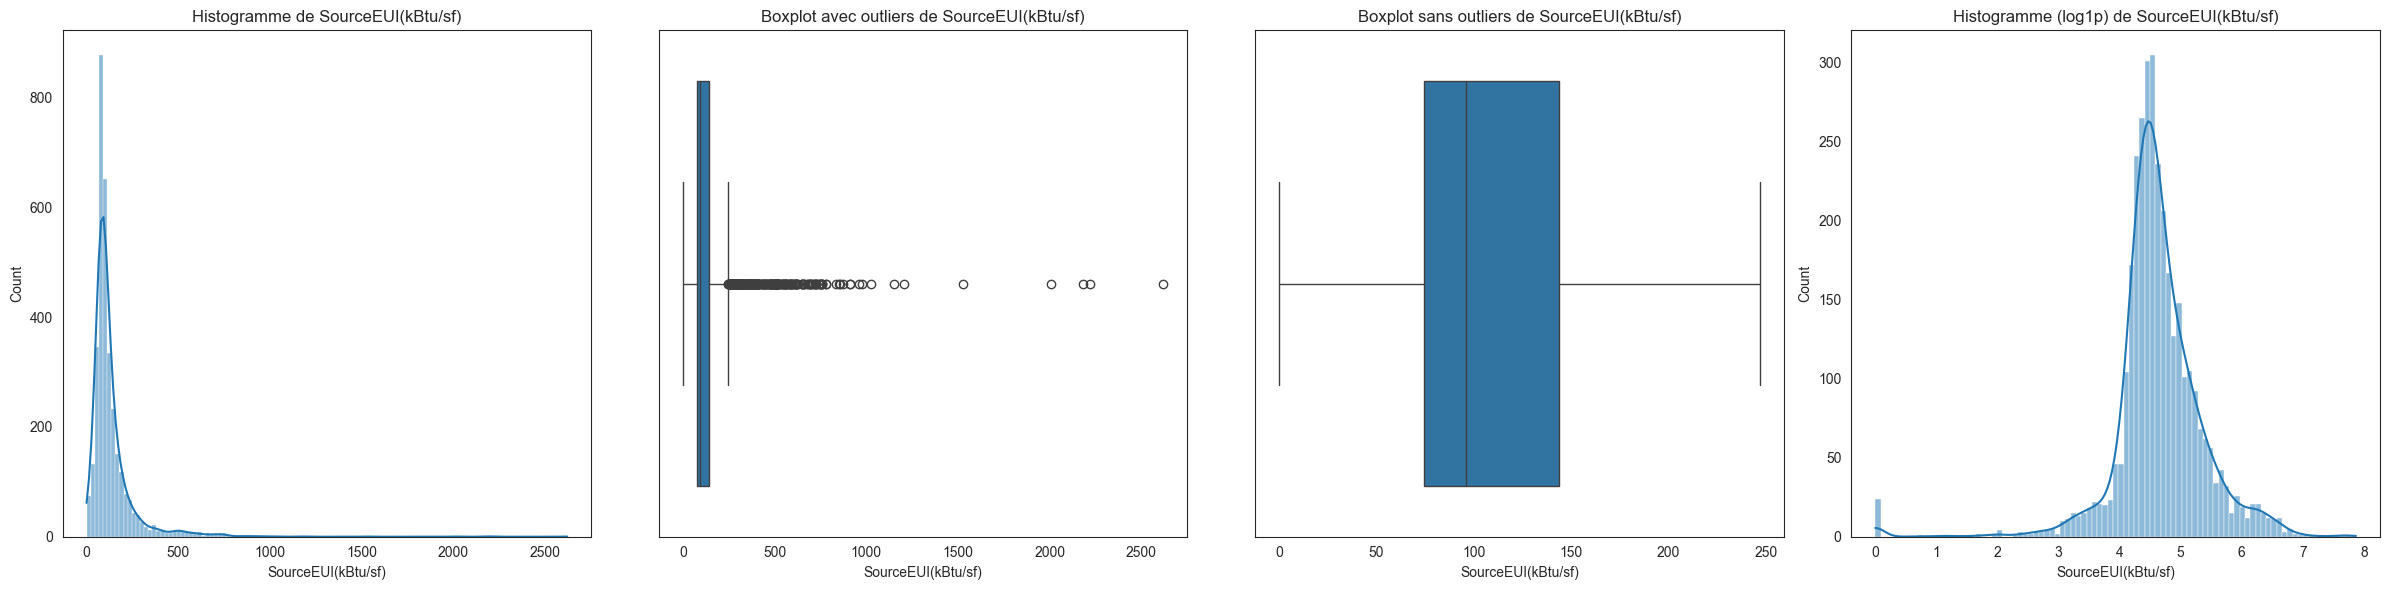

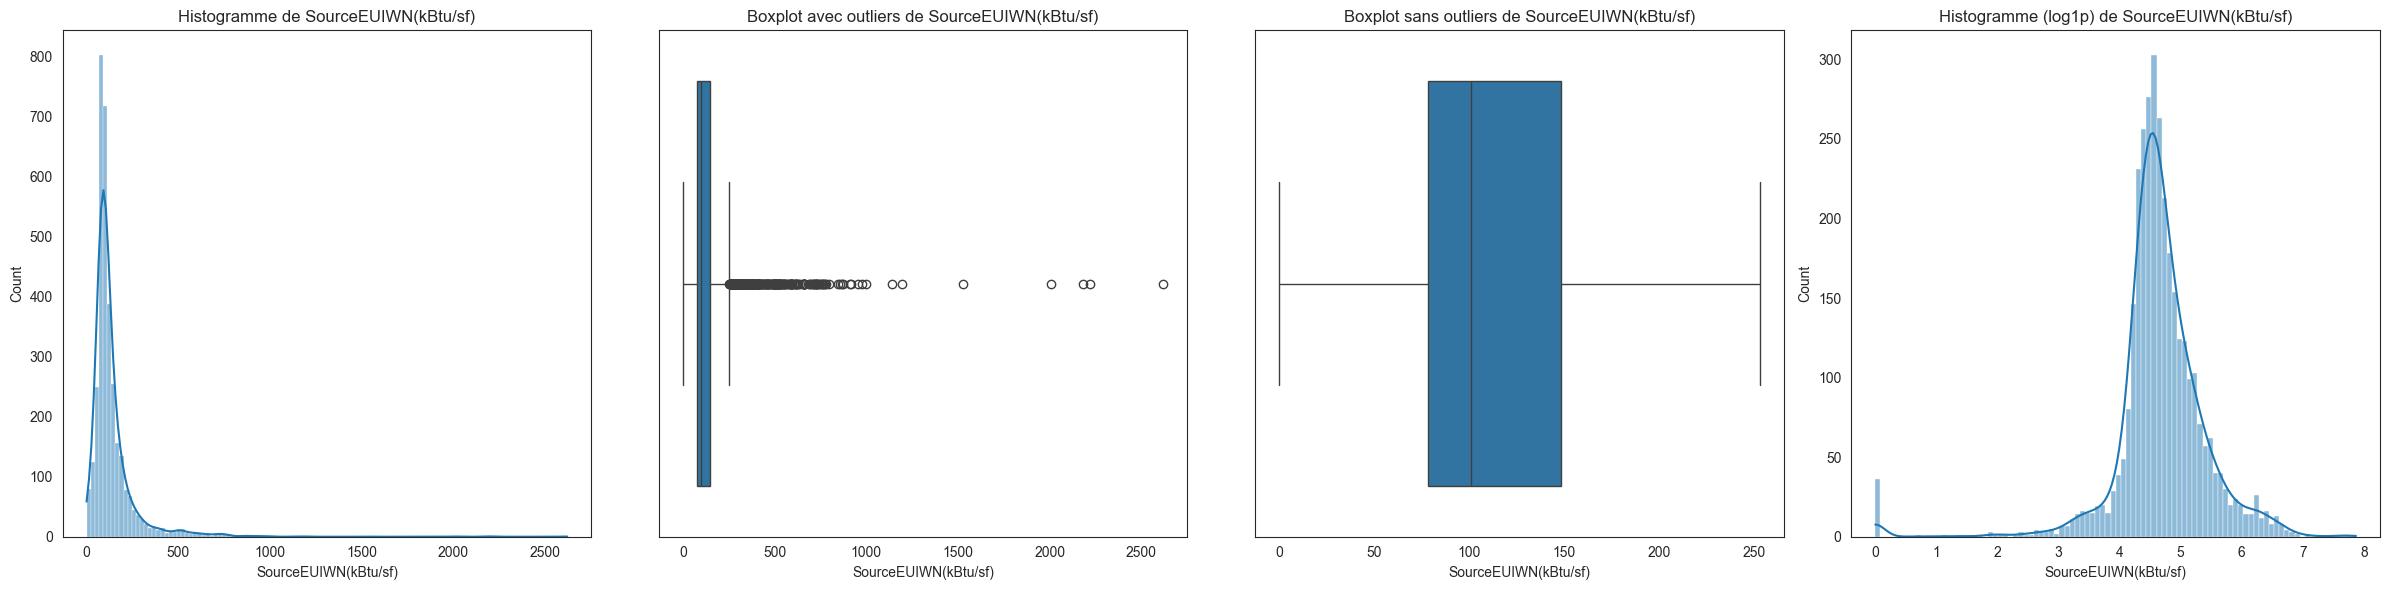

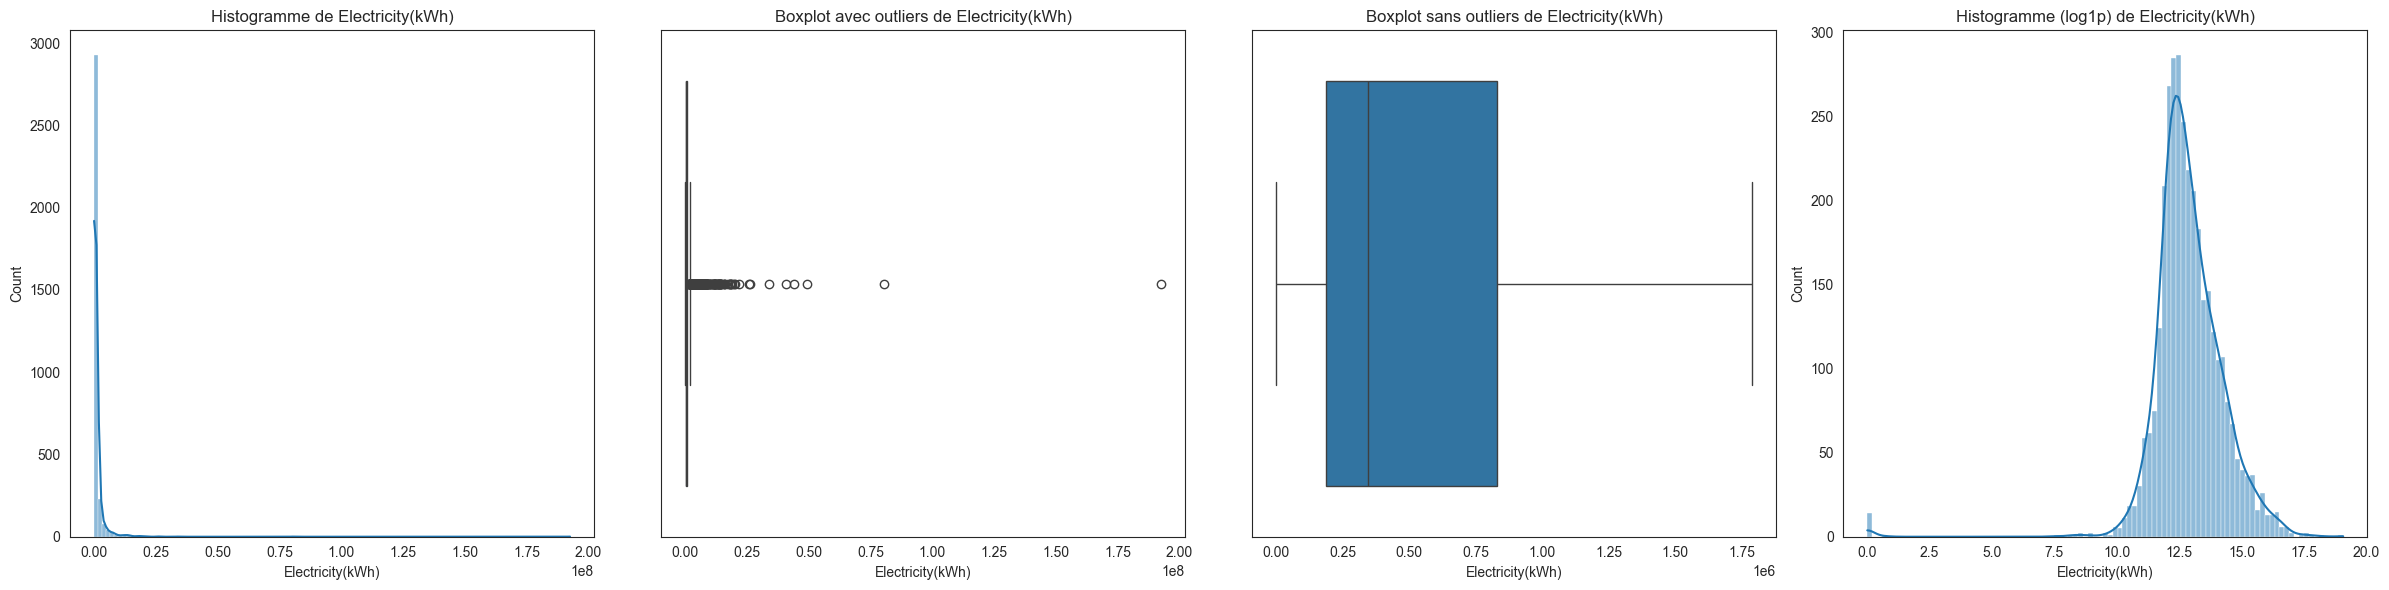

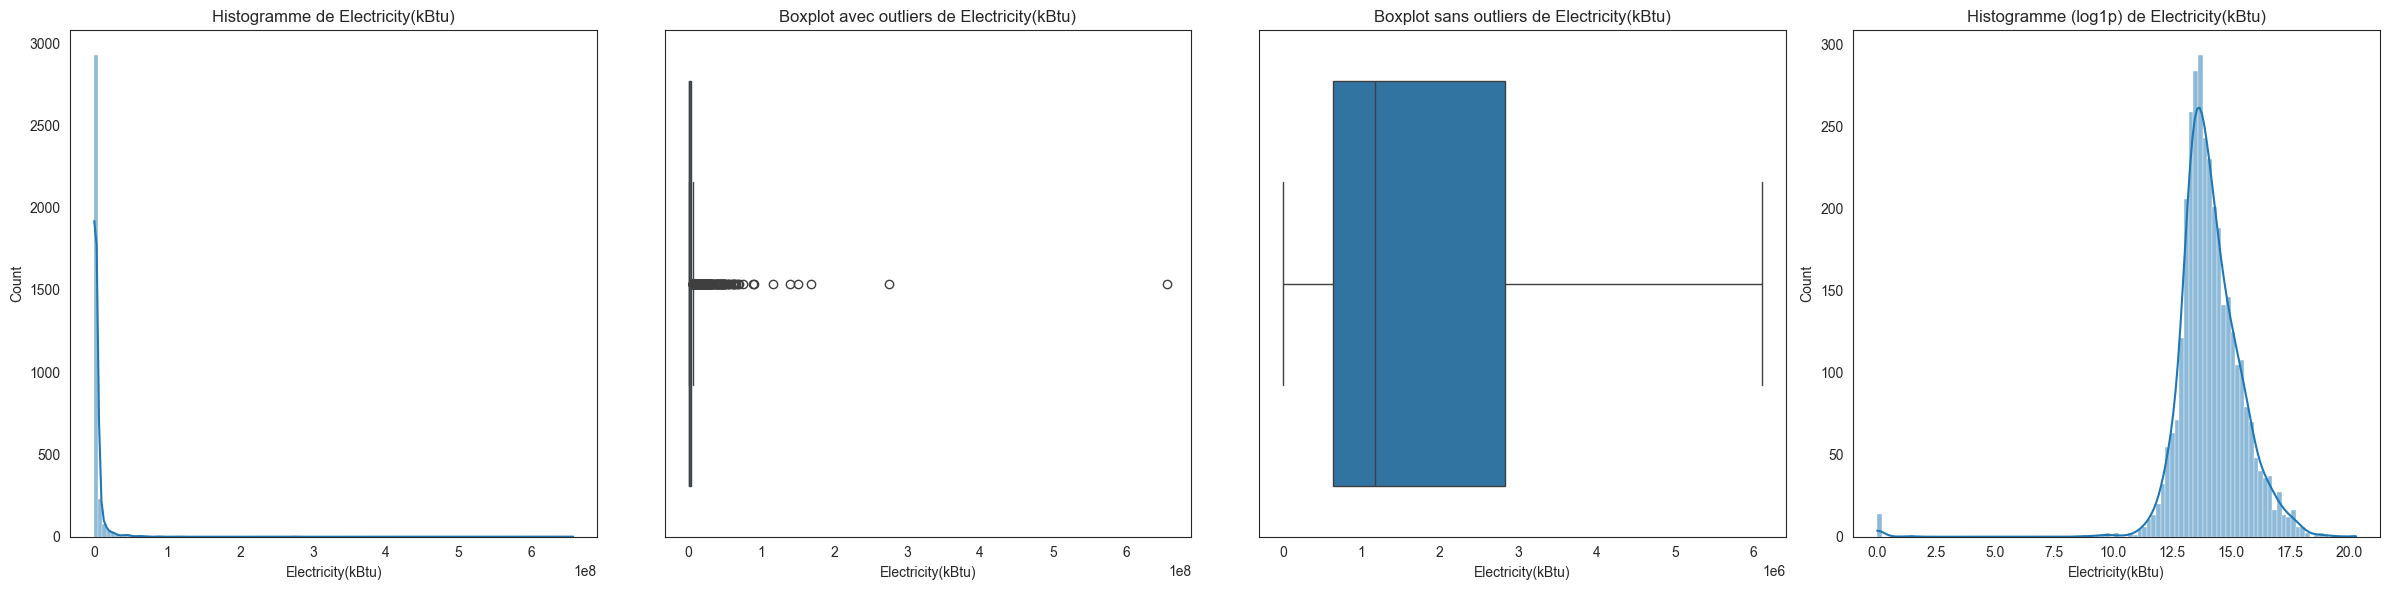

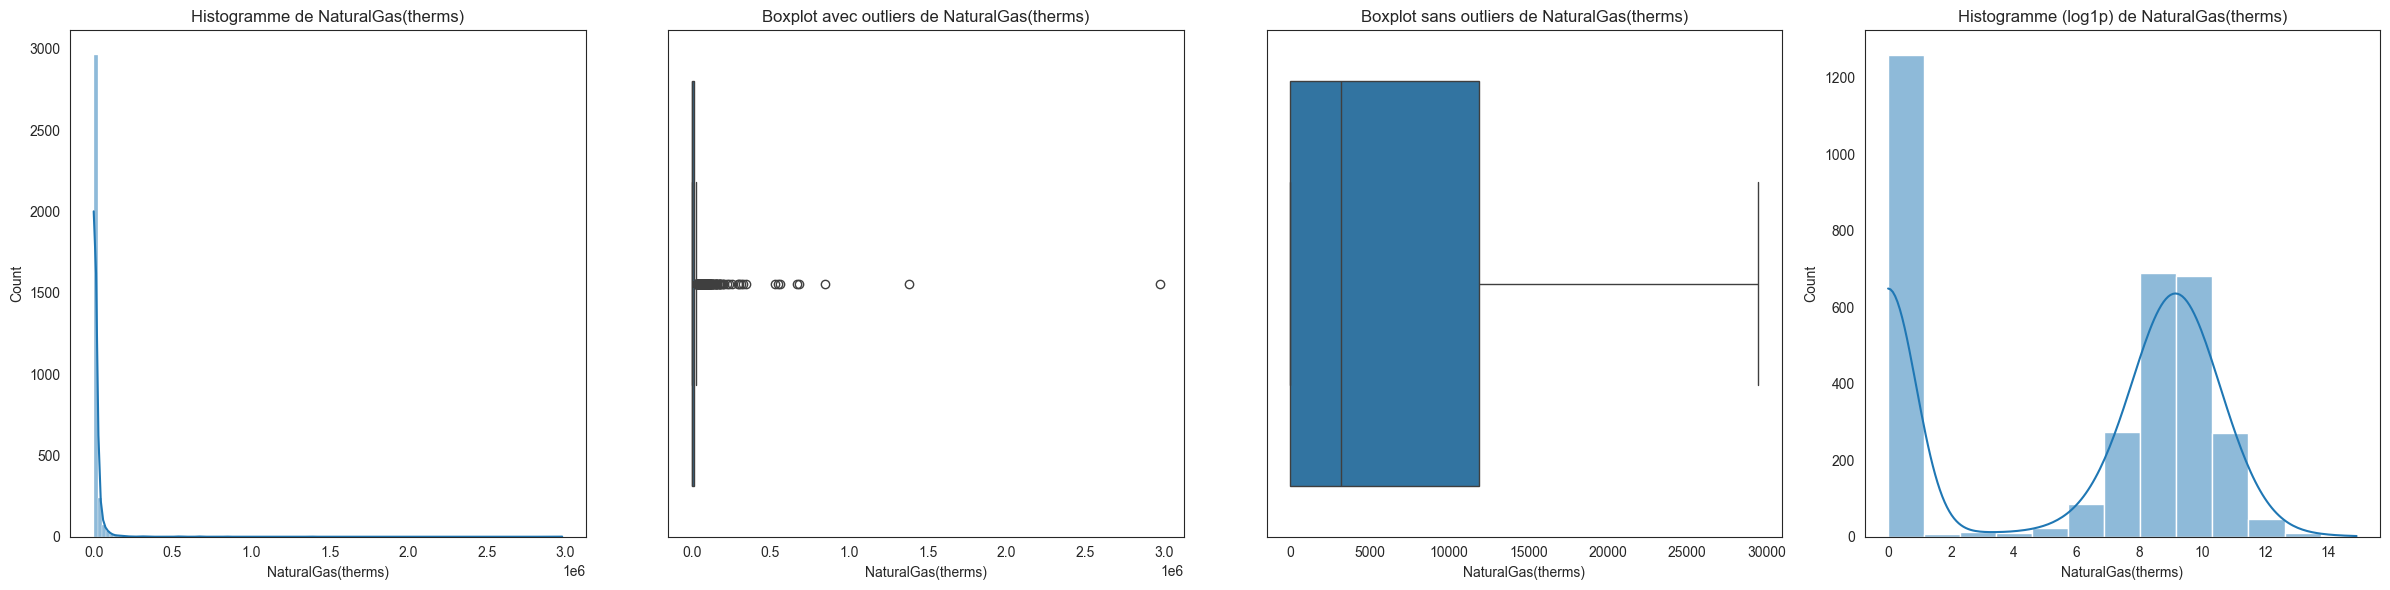

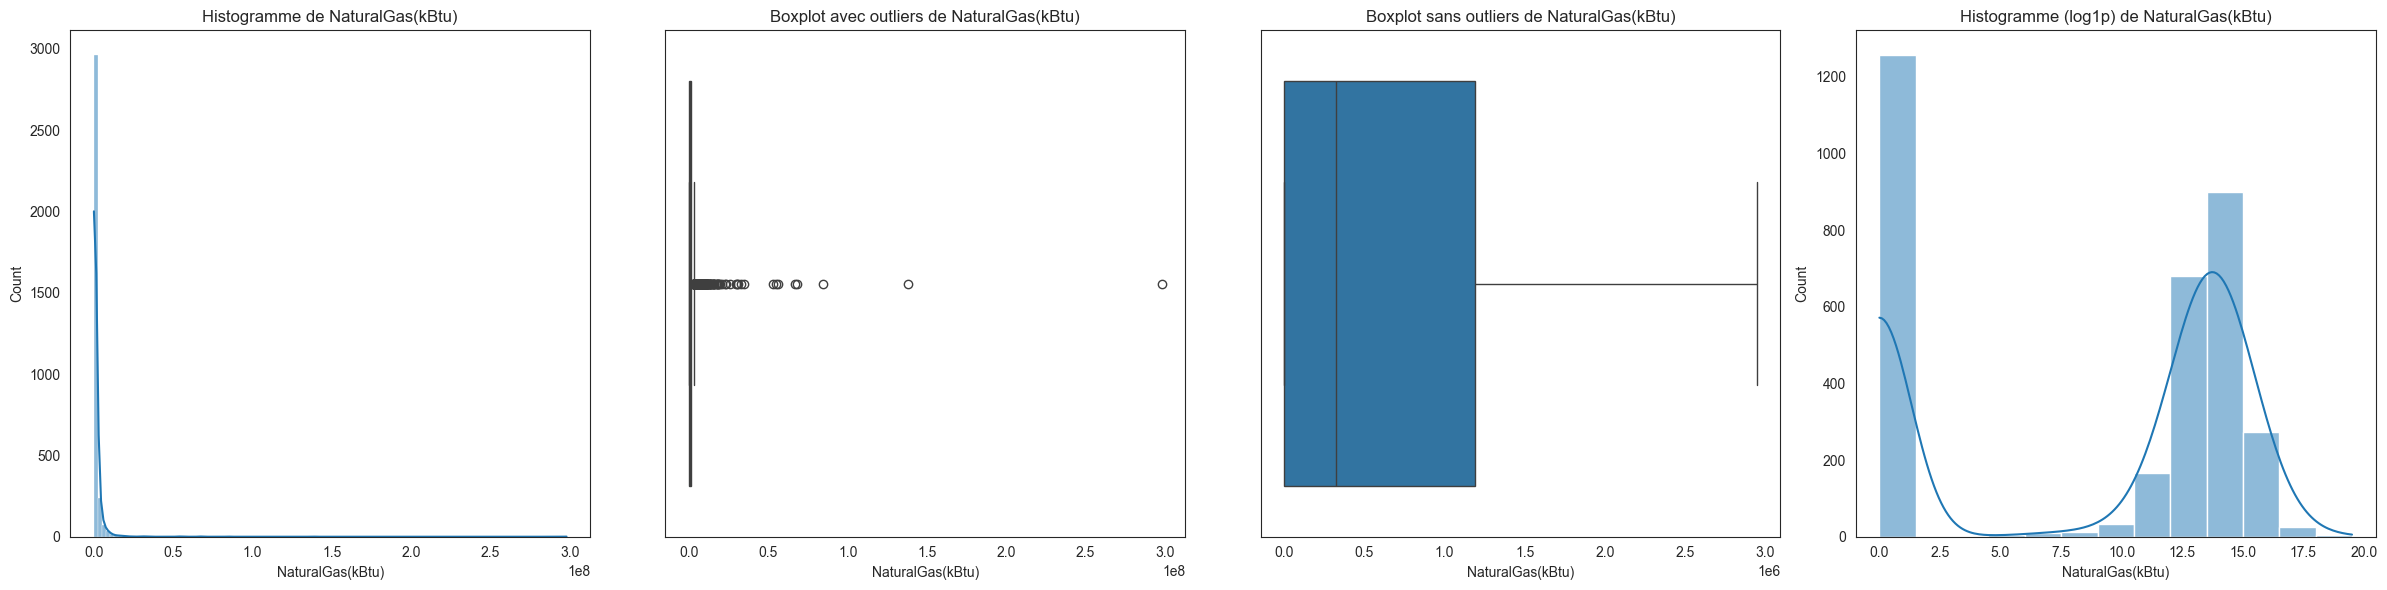

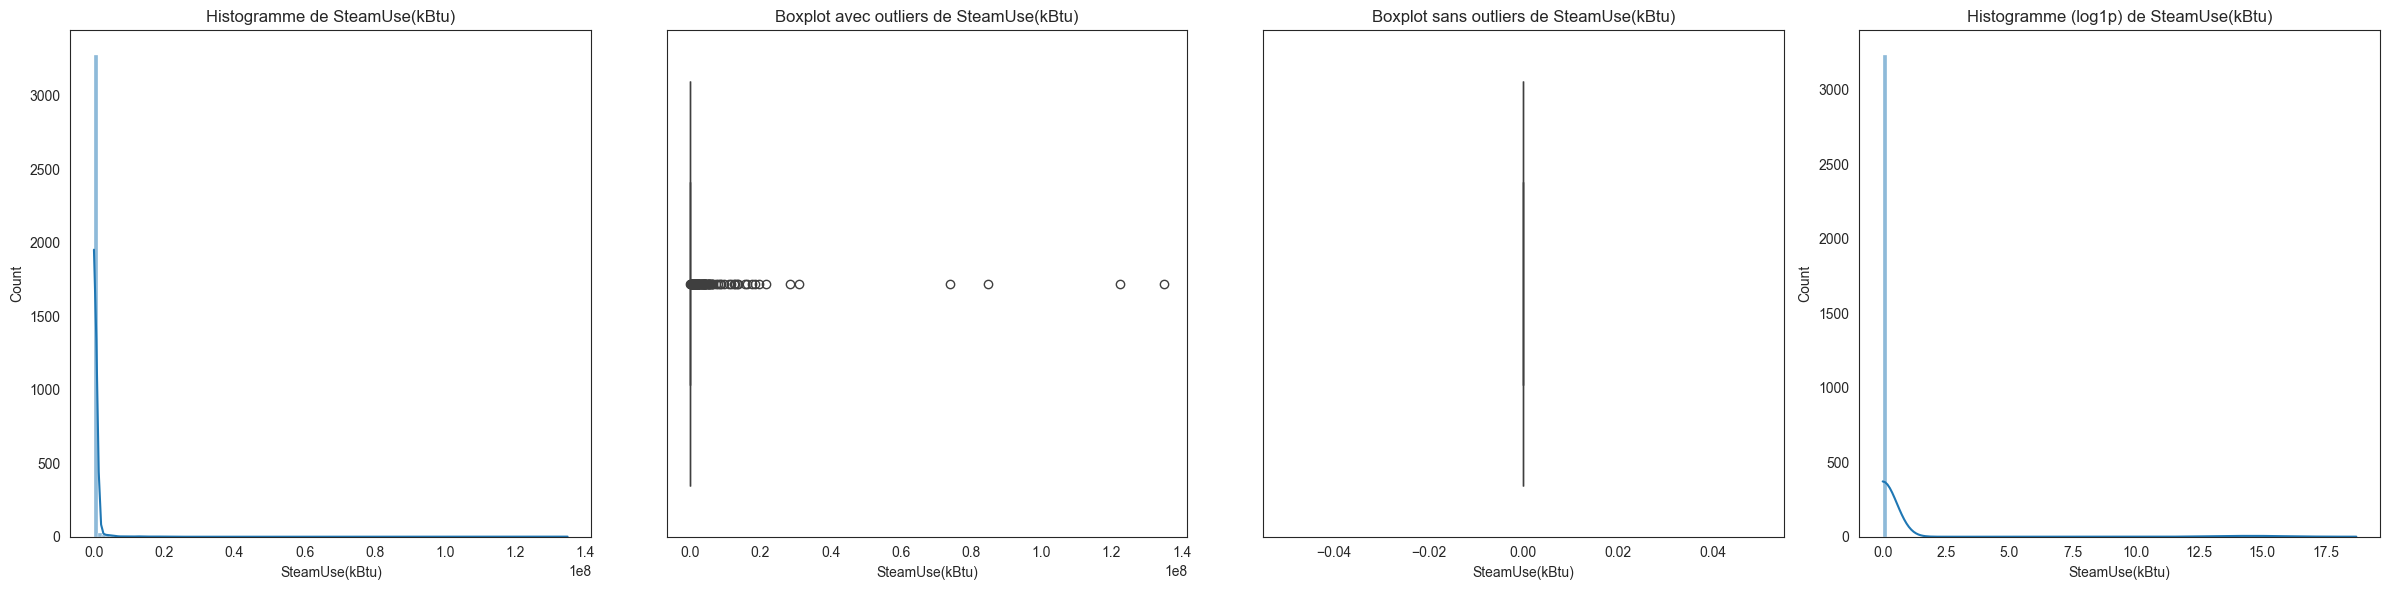

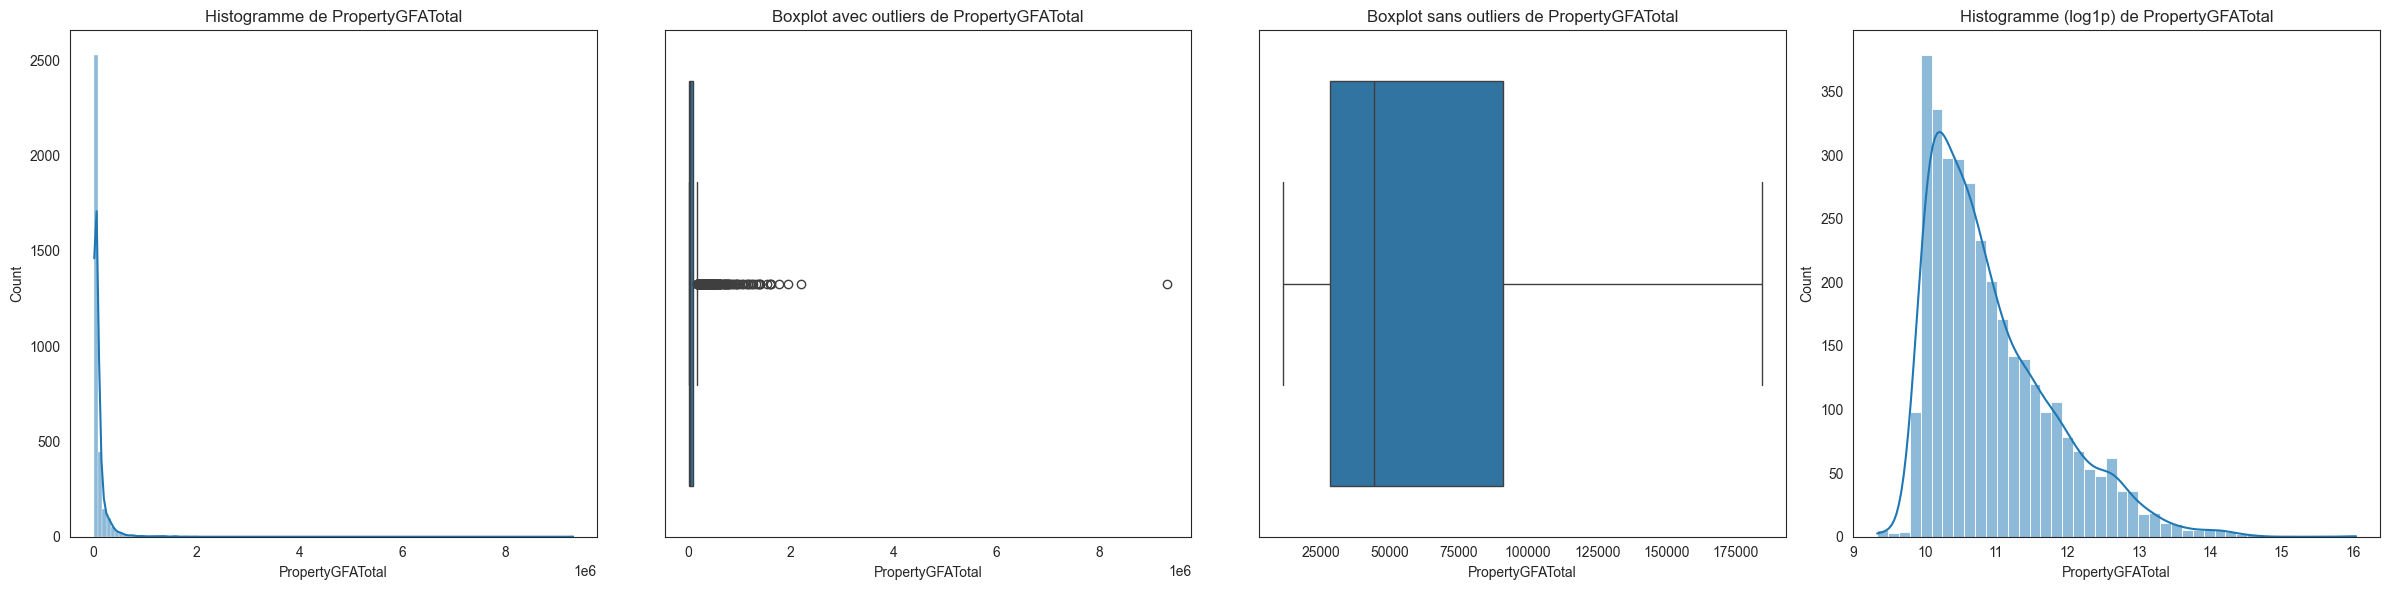

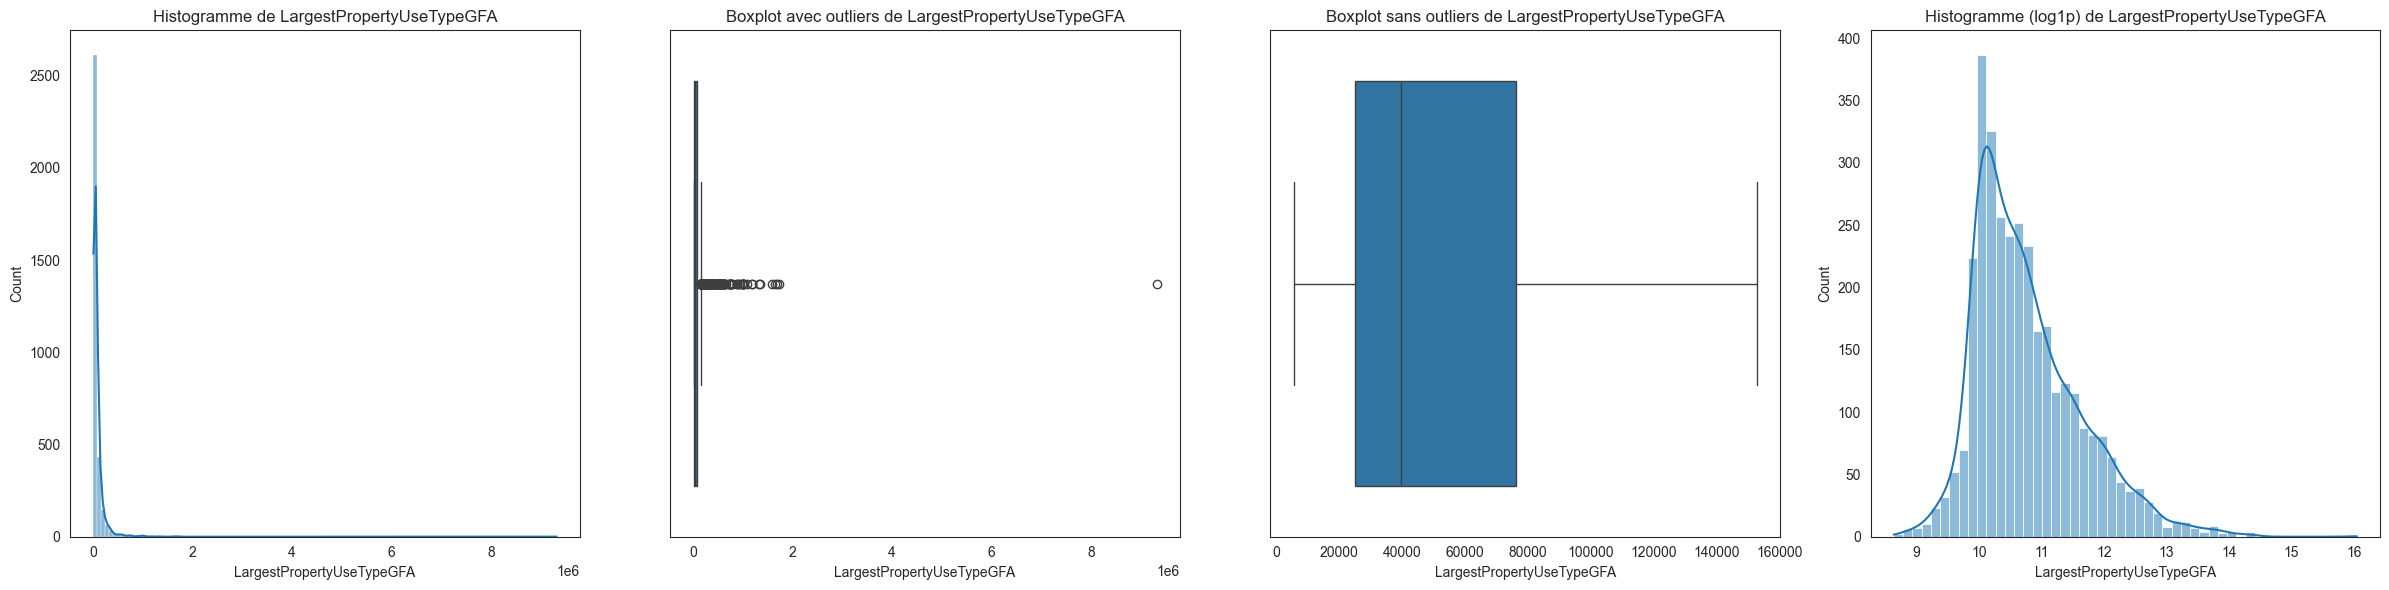

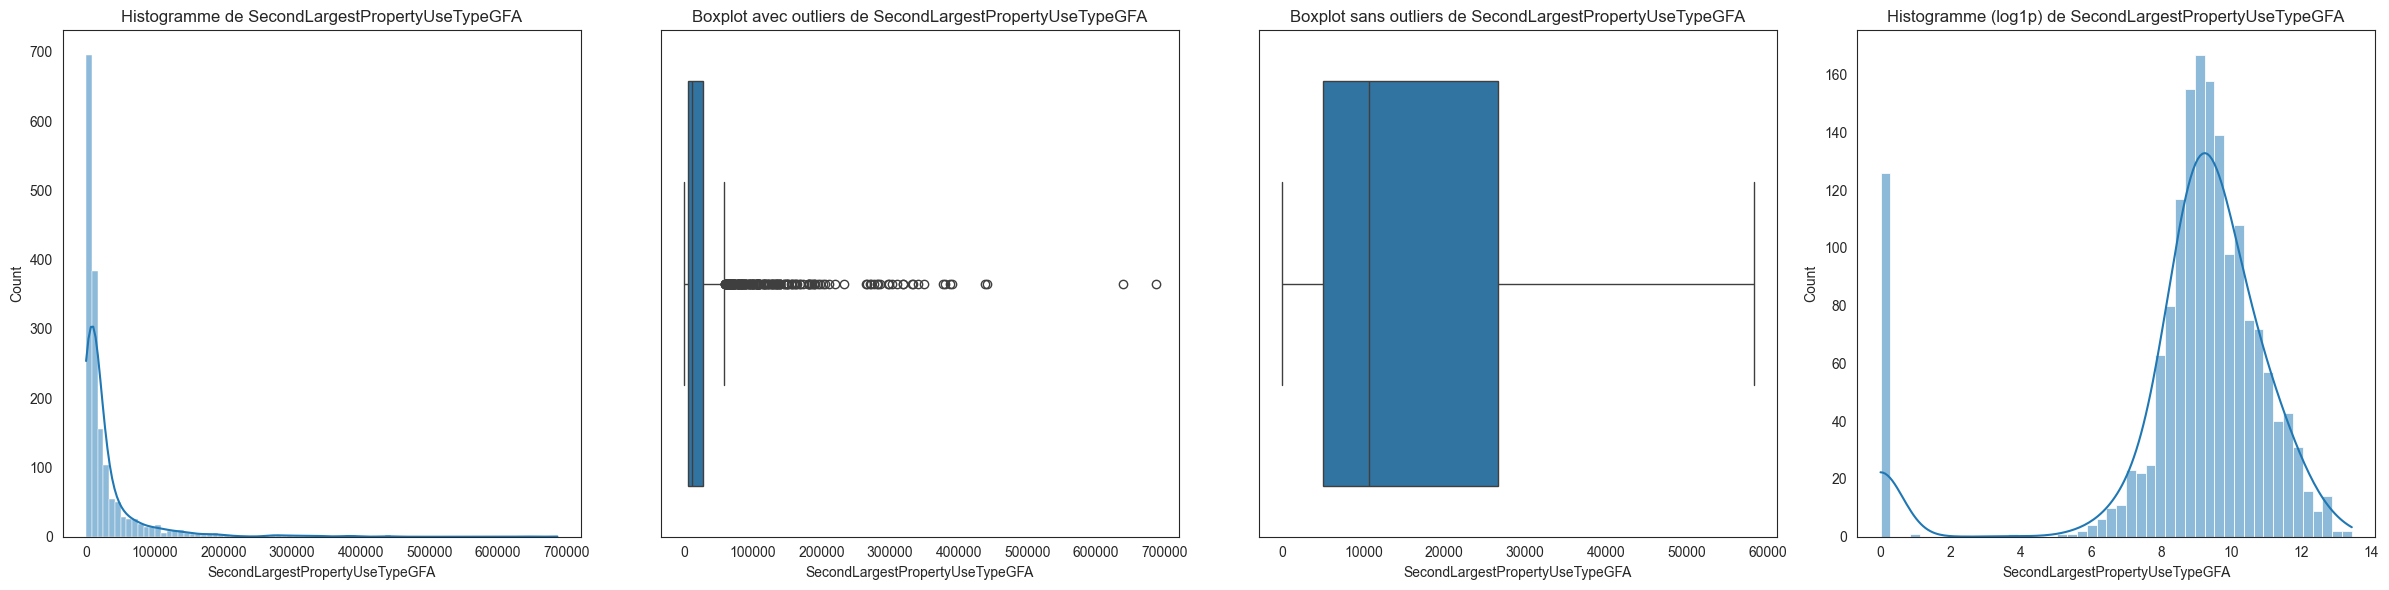

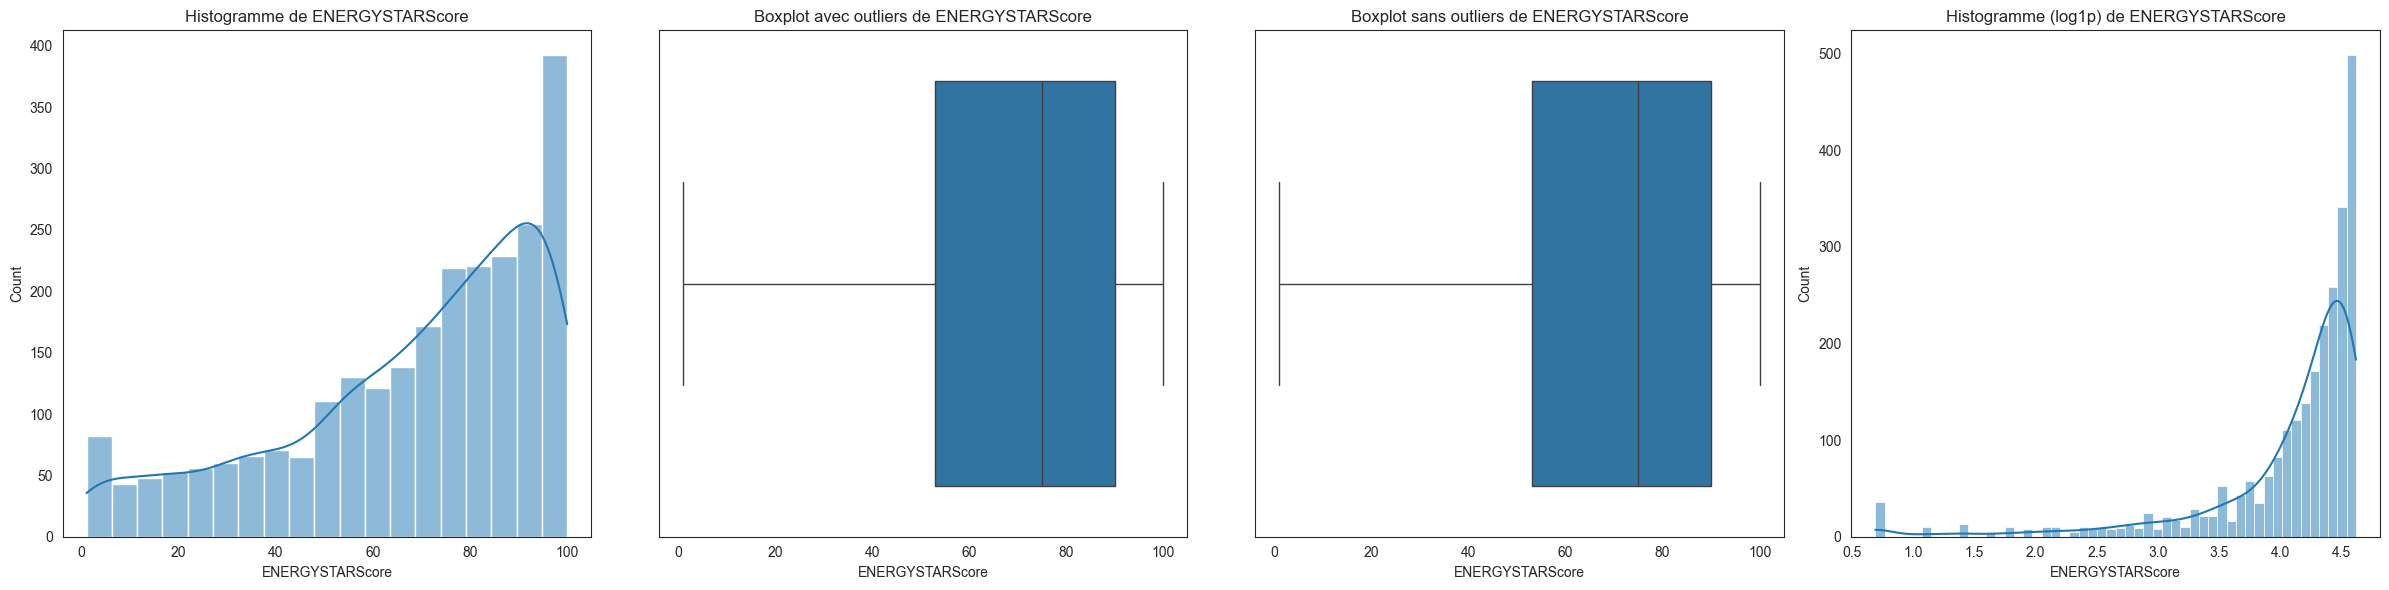

In [13]:

target_cols = [
    'SiteEnergyUse(kBtu)', 
    'SiteEnergyUseWN(kBtu)',
    'TotalGHGEmissions', 
    'GHGEmissionsIntensity', 
    
    # Intensités 
    'SiteEUI(kBtu/sf)', 
    'SiteEUIWN(kBtu/sf)', 
    'SourceEUI(kBtu/sf)', 
    'SourceEUIWN(kBtu/sf)',
    
    # Détail des consommations (Sources d'erreurs fréquentes)
    'Electricity(kWh)', 
    'Electricity(kBtu)', 
    'NaturalGas(therms)', 
    'NaturalGas(kBtu)', 
    'SteamUse(kBtu)', 
    
    # Caractéristiques structurelles 
    'PropertyGFATotal', 
    'LargestPropertyUseTypeGFA', 
    'SecondLargestPropertyUseTypeGFA', 
    'ENERGYSTARScore'
]

# Filtrer les variables présentes dans le dataframe et conserver l'ordre
analyze_cols = [col for col in target_cols if col in df_raw.columns]

def plot_distributions(data, col):
    data_pos = data[data >= 0]

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    # Histogramme brut
    sns.histplot(data_pos, kde=True, ax=axes[0])
    axes[0].set_title(f'Histogramme de {col}')

    # Boxplot avec outliers
    sns.boxplot(x=data_pos, showfliers=True, ax=axes[1])
    axes[1].set_title(f'Boxplot avec outliers de {col}')

    # Boxplot sans outliers
    sns.boxplot(x=data_pos, showfliers=False, ax=axes[2])
    axes[2].set_title(f'Boxplot sans outliers de {col}')

    # Histogramme log-transformé
    sns.histplot(np.log1p(data_pos), kde=True, ax=axes[3])
    axes[3].set_title(f'Histogramme (log1p) de {col}')

    plt.tight_layout()
    return fig


def export_figures(df, cols, output_dir="../figures/notebook_1"):
    """
    Exporte les figures générées pour chaque variable dans un dossier donné.
    """
    for idx, col in enumerate(cols, start=5):
        data = df[col].dropna()
        fig = plot_distributions(data, col)

        # Nettoyer le nom de fichier
        safe_col = re.sub(r'[^\w\-_.]', '_', col)
        filename = f"{output_dir}/{idx}_audit_indicateurs_{safe_col}.png"

        fig.savefig(filename, dpi=300)
        plt.show()


export_figures(df_raw, analyze_cols)


